In [1]:
!pip install nibabel matplotlib opencv-python segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.1 MB/s eta 0:00:00


In [2]:
import os
import zipfile
from google.colab import drive

# 1. 掛載 Google Drive
drive.mount('/content/drive')

# 2. 設定路徑
# 根據你的截圖，檔案路徑位於 /content/drive/MyDrive/CVPDL_final/data_2D.zip
zip_path = '/content/drive/MyDrive/CVPDL_final/data_2D.zip'
extract_path = './2D_dataset' # 解壓到 Colab 本機，讀取速度較快

# 3. 檢查檔案並解壓縮
if os.path.exists(zip_path):
    if not os.path.exists(extract_path):
        print(f"找到檔案：{zip_path}")
        print("正在解壓縮到 Colab 本機 (這可能需要幾秒鐘)...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print("✅ 解壓縮完成！資料已準備好。")
    else:
        print("✅ 資料夾已存在，跳過解壓縮步驟。")
else:
    print(f"❌ 找不到檔案：{zip_path}")
    print("請確認 Google Drive 路徑是否完全正確，包含大小寫。")

# 4. 檢查解壓後的資料結構 (確認一下裡面是不是 Train/Test)
if os.path.exists(extract_path):
    print("資料夾內容預覽：", os.listdir(extract_path))

Mounted at /content/drive
找到檔案：/content/drive/MyDrive/CVPDL_final/data_2D.zip
正在解壓縮到 Colab 本機 (這可能需要幾秒鐘)...
✅ 解壓縮完成！資料已準備好。
資料夾內容預覽： ['metadata_2D.csv', '2D_dataset']


In [ ]:
import os

# 設定你的資料路徑
train_dir = './2D_dataset/2D_dataset/train'
image_dir = os.path.join(train_dir, 'image')
# 這裡同時檢查 label 和 detailed_label 看看哪個存在
label_dirs_to_check = ['label', 'detailed_label', 'rough_label']

print(f"📂 檢查路徑: {train_dir}")

# 1. 檢查圖片資料夾
if os.path.exists(image_dir):
    images = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
    print(f"\n✅ Image 資料夾找到 {len(images)} 張圖片")
    print("   前 5 個檔名範例:")
    for img in images[:5]:
        print(f"   - {img}")
else:
    print(f"\n❌ 找不到 Image 資料夾: {image_dir}")

# 2. 檢查標籤資料夾
print("\n" + "="*30)
for lbl_name in label_dirs_to_check:
    lbl_path = os.path.join(train_dir, lbl_name)
    if os.path.exists(lbl_path):
        labels = sorted([f for f in os.listdir(lbl_path) if not f.startswith('.')])
        print(f"\n✅ 找到標籤資料夾: {lbl_name} (共 {len(labels)} 個檔案)")
        print(f"   前 5 個 {lbl_name} 檔名範例:")
        for lbl in labels[:5]:
            print(f"   - {lbl}")
    else:
        print(f"\n❌ 找不到資料夾: {lbl_name}")

📂 檢查路徑: ./2D_dataset/2D_dataset/train

✅ Image 資料夾找到 12564 張圖片
   前 5 個檔名範例:
   - 0_0_THIGH_001_Fat.nii.gz
   - 0_10_THIGH_001_Fat.nii.gz
   - 0_11_THIGH_001_Fat.nii.gz
   - 0_12_THIGH_001_Fat.nii.gz
   - 0_13_THIGH_001_Fat.nii.gz


❌ 找不到資料夾: label

✅ 找到標籤資料夾: detailed_label (共 5400 個檔案)
   前 5 個 detailed_label 檔名範例:
   - 0_0_THIGH_001_Fat_detailed.nii.gz
   - 0_10_THIGH_001_Fat_detailed.nii.gz
   - 0_11_THIGH_001_Fat_detailed.nii.gz
   - 0_12_THIGH_001_Fat_detailed.nii.gz
   - 0_13_THIGH_001_Fat_detailed.nii.gz

✅ 找到標籤資料夾: rough_label (共 12564 個檔案)
   前 5 個 rough_label 檔名範例:
   - 0_0_THIGH_001_Fat_rough.nii.gz
   - 0_10_THIGH_001_Fat_rough.nii.gz
   - 0_11_THIGH_001_Fat_rough.nii.gz
   - 0_12_THIGH_001_Fat_rough.nii.gz
   - 0_13_THIGH_001_Fat_rough.nii.gz


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import cv2
import nibabel as nib

# 標籤映射字典
ROUGH_MAPPING = {
    1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

class ThighMuscleNiftiDataset(Dataset):
    def __init__(self, root_dir, split='train', target_size=(256, 256)):
        self.split = split
        self.target_size = target_size

        self.image_dir = os.path.join(root_dir, split, 'image')
        self.detailed_dir = os.path.join(root_dir, split, 'detailed_label')
        self.rough_dir = os.path.join(root_dir, split, 'rough_label')

        # 讀取所有影像路徑
        if os.path.exists(self.image_dir):
            self.image_paths = sorted(glob.glob(os.path.join(self.image_dir, '*.nii.gz')))
        else:
            self.image_paths = []

        # 檢查 rough label
        if os.path.exists(self.rough_dir):
            self.rough_paths = sorted(glob.glob(os.path.join(self.rough_dir, '*.nii.gz')))
            self.has_rough_files = len(self.rough_paths) > 0
        else:
            self.has_rough_files = False

        print(f"[{split}] 載入 {len(self.image_paths)} 筆資料")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        data = data.astype(np.float32)
        min_val = np.min(data)
        max_val = np.max(data)
        if max_val - min_val > 0:
            return (data - min_val) / (max_val - min_val)
        return data

    def map_detailed_to_rough(self, detailed_mask):
        rough_mask = np.zeros_like(detailed_mask)
        for det_idx, rough_idx in ROUGH_MAPPING.items():
            rough_mask[detailed_mask == det_idx] = rough_idx
        return rough_mask

    def resize_image(self, img, is_mask=False):
        if is_mask:
            return cv2.resize(img, self.target_size, interpolation=cv2.INTER_NEAREST)
        else:
            return cv2.resize(img, self.target_size, interpolation=cv2.INTER_LINEAR)

    def find_label_file(self, img_filename):
        """
        修正後的邏輯：處理 _detailed 後綴
        例如: img='xxx.nii.gz' -> lbl='xxx_detailed.nii.gz'
        """
        # 1. 嘗試加上 _detailed (這是你的資料集格式)
        # 將 "xxx.nii.gz" 變為 "xxx_detailed.nii.gz"
        name_with_suffix = img_filename.replace('.nii.gz', '_detailed.nii.gz')
        path = os.path.join(self.detailed_dir, name_with_suffix)
        if os.path.exists(path):
            return path

        # 2. 如果上面找不到，嘗試直接用原檔名 (有些資料可能沒有加)
        path = os.path.join(self.detailed_dir, img_filename)
        if os.path.exists(path):
            return path

        return None

    def __getitem__(self, idx):
        # 1. 讀取影像
        img_path = self.image_paths[idx]
        nii_img = nib.load(img_path)
        image_data = nii_img.get_fdata()
        if len(image_data.shape) == 3: image_data = np.squeeze(image_data)

        image_data = self.resize_image(image_data, is_mask=False)
        image_data = self.normalize(image_data)
        image = np.stack([image_data]*3, axis=0)

        # 2. 讀取 Label (使用修正後的邏輯)
        fname = os.path.basename(img_path)
        det_path = self.find_label_file(fname)

        if det_path and os.path.exists(det_path):
            nii_lbl = nib.load(det_path)
            det_mask = nii_lbl.get_fdata()
            if len(det_mask.shape) == 3: det_mask = np.squeeze(det_mask)
            det_mask = self.resize_image(det_mask, is_mask=True)
        else:
            # 還是找不到，給全黑並印出警告 (但在這裡我們先不印避免洗版)
            det_mask = np.zeros(self.target_size)

        # 3. Rough Label
        rough_mask = self.map_detailed_to_rough(det_mask)

        return torch.from_numpy(image).float(), torch.from_numpy(det_mask).long(), torch.from_numpy(rough_mask).long()

# --- 重新執行 Dataset 設定 ---
dataset_root = './2D_dataset/2D_dataset'
train_dataset = ThighMuscleNiftiDataset(root_dir=dataset_root, split='train', target_size=(256, 256))
test_dataset = ThighMuscleNiftiDataset(root_dir=dataset_root, split='test', target_size=(256, 256))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print("✅ Dataset 已修正：現在會自動尋找 '_detailed.nii.gz' 檔案。")

[train] 載入 12564 筆資料
[test] 載入 1055 筆資料
✅ Dataset 已修正：現在會自動尋找 '_detailed.nii.gz' 檔案。


In [ ]:
# Cell 1: Robust Dataset with Suffix Handling
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import cv2
import nibabel as nib

# 標籤映射字典 (詳細 -> 粗略)
# 這是根據您之前提供的邏輯
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

class ThighMultiTaskDataset(Dataset):
    def __init__(self, root_dir, split='train', target_size=(256, 256)):
        self.split = split
        self.target_size = target_size

        # 設定路徑
        self.base_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.base_dir, 'image')
        self.detailed_dir = os.path.join(self.base_dir, 'detailed_label')

        self.data_pairs = [] # 儲存 (image_path, label_path) 的配對

        # === 核心修正：以 detailed_label 為基準進行配對 ===
        if os.path.exists(self.detailed_dir) and os.path.exists(self.image_dir):
            # 1. 取得所有詳細標籤的檔名
            label_files = sorted(glob.glob(os.path.join(self.detailed_dir, '*_detailed.nii.gz')))

            print(f"[{split}] 掃描到 {len(label_files)} 個詳細標籤，正在配對圖片...")

            for lbl_path in label_files:
                lbl_name = os.path.basename(lbl_path)

                # 2. 推導對應的圖片檔名
                # 邏輯：把 "_detailed.nii.gz" 替換成 ".nii.gz"
                # 例如：0_0_THIGH_001_Fat_detailed.nii.gz -> 0_0_THIGH_001_Fat.nii.gz
                img_name = lbl_name.replace('_detailed.nii.gz', '.nii.gz')
                img_path = os.path.join(self.image_dir, img_name)

                # 3. 檢查圖片是否存在
                if os.path.exists(img_path):
                    self.data_pairs.append((img_path, lbl_path))

            print(f"✅ [{split}] 成功配對 {len(self.data_pairs)} 組資料 (圖片 + 詳細標籤)。")
        else:
            print(f"❌ [{split}] 錯誤：找不到 image 或 detailed_label 資料夾！")

    def __len__(self):
        return len(self.data_pairs)

    def map_detailed_to_rough(self, detailed_mask):
        rough_mask = np.zeros_like(detailed_mask)
        for det_idx, rough_idx in ROUGH_MAPPING.items():
            rough_mask[detailed_mask == det_idx] = rough_idx
        return rough_mask

    def resize_image(self, img, is_mask=False):
        method = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        return cv2.resize(img, self.target_size, interpolation=method)

    def normalize(self, data):
        data = data.astype(np.float32)
        if data.max() > 0:
            return data / data.max()
        return data

    def __getitem__(self, idx):
        img_path, lbl_path = self.data_pairs[idx]

        try:
            # 1. 讀取影像
            nii_img = nib.load(img_path)
            image_data = nii_img.get_fdata()
            if image_data.ndim == 3: image_data = np.squeeze(image_data)

            # 2. 讀取標籤
            nii_lbl = nib.load(lbl_path)
            det_mask = nii_lbl.get_fdata()
            if det_mask.ndim == 3: det_mask = np.squeeze(det_mask)

            # 3. Resize & Normalize
            image_data = self.resize_image(image_data, is_mask=False)
            image_data = self.normalize(image_data)

            det_mask = self.resize_image(det_mask, is_mask=True)

            # 4. 產生 Rough Label (從 Detailed 轉換，保證一致性)
            rough_mask = self.map_detailed_to_rough(det_mask)

            # 5. 轉 Tensor (Image 轉成 3 channels 供 ResNet 使用)
            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            det_tensor = torch.from_numpy(det_mask).long()
            rough_tensor = torch.from_numpy(rough_mask).long()

            return image_tensor, det_tensor, rough_tensor

        except Exception as e:
            print(f"Error loading {os.path.basename(img_path)}: {e}")
            # 遇到錯誤回傳全 0 (避免卡住)
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size).long(), torch.zeros(self.target_size).long()

print("Dataset Class Fixed & Ready.")

Dataset Class Fixed & Ready.


In [ ]:
# Cell 2: Model Definition (Fix Forward Pass)
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import torch

# 設定裝置
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. 載入預訓練的 U-Net (ResNet34)
        # 這裡 classes=1 只是為了初始化，我們會忽略原本的 head
        self.backbone = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )

        # 提取 Encoder 和 Decoder
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder

        # 2. 定義兩個新的輸出頭 (Heads)
        # SMP Unet 的 Decoder 預設最後一層輸出通道數為 16
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)   # 粗略分類 (5類)
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1) # 詳細分類 (12類)

    def forward(self, x):
        # 1. Encoder 提取特徵 (回傳一個 list，包含不同尺度的特徵圖)
        features = self.encoder(x)

        # 2. Decoder 解碼
        # 修正重點：根據錯誤訊息，Decoder 可能只接受一個 list 參數，而不是拆開的參數
        try:
            # 嘗試直接傳入 list
            decoder_output = self.decoder(*features)
        except TypeError:
            # 如果報錯 "takes 2 positional arguments but 7 were given"，則傳入 list 本身
            decoder_output = self.decoder(features)

        # 3. 通過兩個不同的 Heads
        out_rough = self.head_rough(decoder_output)
        out_detailed = self.head_detailed(decoder_output)

        return out_rough, out_detailed

print("✅ Model Class Fixed & Defined.")

✅ Model Class Fixed & Defined.


In [ ]:
# Cell 3: Training Execution (Fix NameError)
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from google.colab import drive

# === 補上缺失的變數定義 ===
DATASET_ROOT = './2D_dataset/2D_dataset'
# ==========================

# 參數設定
BATCH_SIZE = 16
LR = 0.0005
EPOCHS = 30

def run_training():
    # 1. 準備資料
    print("Loading Full Training Data...")

    # 這裡原本報錯，現在因為上面定義了 DATASET_ROOT，應該可以正常運作
    full_dataset = ThighMultiTaskDataset(DATASET_ROOT, split='train')

    if len(full_dataset) == 0:
        print("❌ Error: Dataset is empty. Training aborted.")
        return None

    # 2. 切分 Train/Val (80% / 20%)
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size

    train_set, val_set = random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"🚀 Training on {DEVICE} | Train Size: {len(train_set)} | Val Size: {len(val_set)}")

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 3. 初始化模型與優化器
    model = MultiHeadUNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': []}

    # 4. 訓練迴圈
    for epoch in range(EPOCHS):
        # --- Train ---
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

        for imgs, det_masks, rough_masks in loop:
            imgs = imgs.to(DEVICE)
            det_masks = det_masks.to(DEVICE)
            rough_masks = rough_masks.to(DEVICE)

            optimizer.zero_grad()

            # Forward
            out_rough, out_detailed = model(imgs)

            # Loss = Rough Loss + Detailed Loss
            loss = criterion(out_rough, rough_masks) + criterion(out_detailed, det_masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Val ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, det_masks, rough_masks in val_loader:
                imgs = imgs.to(DEVICE)
                det_masks = det_masks.to(DEVICE)
                rough_masks = rough_masks.to(DEVICE)

                out_rough, out_detailed = model(imgs)
                loss = criterion(out_rough, rough_masks) + criterion(out_detailed, det_masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"   Result: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 5. 儲存模型 (本地端 + Google Drive)
    model_save_name = 'thigh_multitask_model.pth'

    # 儲存到 Colab 本地
    torch.save(model.state_dict(), model_save_name)
    print(f"✅ Model saved locally as {model_save_name}")

    # --- 儲存到 Google Drive ---
    try:
        if not os.path.exists('/content/drive'):
             print("💾 Mounting Google Drive...")
             drive.mount('/content/drive')

        drive_folder = '/content/drive/MyDrive/CVPDL_final/'

        if not os.path.exists(drive_folder):
            os.makedirs(drive_folder)
            print(f"Created directory: {drive_folder}")

        save_path = os.path.join(drive_folder, model_save_name)
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model successfully backed up to Google Drive: {save_path}")

    except Exception as e:
        print(f"⚠️ Warning: Failed to save to Google Drive. Error: {e}")

    return model

print("Training Function Ready (With DATASET_ROOT fix).")

Training Function Ready (With DATASET_ROOT fix).


In [ ]:
# Cell 6: Execute
if __name__ == '__main__':
    # 1. 執行訓練
    # 這會呼叫我們剛剛在 Cell 3 定義的 run_training 函式
    trained_model = run_training()

    # 2. 視覺化測試結果
    # 確保模型訓練成功後，再對測試集進行推論與繪圖
    if trained_model:
        analyze_results(trained_model)

Loading Full Training Data...
[train] 掃描到 5400 個詳細標籤，正在配對圖片...
✅ [train] 成功配對 5400 組資料 (圖片 + 詳細標籤)。
🚀 Training on cuda | Train Size: 4320 | Val Size: 1080


Epoch 1/30 [Train]: 100%|██████████| 270/270 [01:07<00:00,  4.02it/s, loss=1.33]


   Result: Train Loss: 2.4387 | Val Loss: 1.3591


Epoch 2/30 [Train]:   5%|▍         | 13/270 [00:04<01:22,  3.10it/s, loss=1.24]


KeyboardInterrupt: 

In [ ]:
import os
import shutil
from google.colab import drive

# 1. 確保 Google Drive 已掛載
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. 設定路徑
source_path = './thigh_multitask_model.pth'  # Colab 目前的位置
# 這是你之前用的專案路徑，建議存這裡比較好找
destination_folder = '/content/drive/MyDrive/CVPDL_final/'
destination_path = os.path.join(destination_folder, 'thigh_multitask_model.pth')

# 3. 執行複製
if os.path.exists(source_path):
    # 如果目標資料夾不存在，自動建立
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        print(f"📂 建立資料夾: {destination_folder}")

    print(f"💾 正在將模型備份到 Google Drive...")
    shutil.copy(source_path, destination_path)

    if os.path.exists(destination_path):
        print(f"✅ 成功！模型已儲存至: {destination_path}")
    else:
        print("❌ 備份失敗，請檢查 Google Drive 空間是否足夠。")
else:
    print(f"❌ 找不到檔案 {source_path}，請確認模型是否已訓練完成。")

In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import os
import glob
import numpy as np
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# === 1. 設定參數 ===
DATASET_ROOT = './2D_dataset/2D_dataset'
MODEL_PATH = './thigh_multitask_model.pth' # 你現有的模型路徑
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 256

# 詳細 -> 粗略 對照表
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

# === 2. 定義資料集 (確保能讀取圖片) ===
class ThighMultiTaskDataset(Dataset):
    def __init__(self, root_dir, split='test', target_size=(256, 256)):
        self.split = split
        self.target_size = target_size
        self.base_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.base_dir, 'image')
        self.detailed_dir = os.path.join(self.base_dir, 'detailed_label')
        self.data_pairs = []

        if os.path.exists(self.detailed_dir) and os.path.exists(self.image_dir):
            label_files = sorted(glob.glob(os.path.join(self.detailed_dir, '*_detailed.nii.gz')))
            for lbl_path in label_files:
                lbl_name = os.path.basename(lbl_path)
                img_name = lbl_name.replace('_detailed.nii.gz', '.nii.gz')
                img_path = os.path.join(self.image_dir, img_name)
                if os.path.exists(img_path):
                    self.data_pairs.append((img_path, lbl_path))
            print(f"[{split}] 載入 {len(self.data_pairs)} 組影像。")

    def __len__(self):
        return len(self.data_pairs)

    def resize_image(self, img, is_mask=False):
        method = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        return cv2.resize(img, self.target_size, interpolation=method)

    def normalize(self, data):
        data = data.astype(np.float32)
        if data.max() > 0: return data / data.max()
        return data

    def __getitem__(self, idx):
        img_path, lbl_path = self.data_pairs[idx]
        try:
            nii_img = nib.load(img_path)
            image_data = np.squeeze(nii_img.get_fdata())
            nii_lbl = nib.load(lbl_path)
            det_mask = np.squeeze(nii_lbl.get_fdata())

            image_data = self.normalize(self.resize_image(image_data, is_mask=False))
            det_mask = self.resize_image(det_mask, is_mask=True)
            rough_mask = np.zeros_like(det_mask)
            for d, r in ROUGH_MAPPING.items(): rough_mask[det_mask == d] = r

            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            return image_tensor, torch.from_numpy(det_mask).long(), torch.from_numpy(rough_mask).long()
        except:
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size), torch.zeros(self.target_size)

# === 3. 定義模型架構 (必須與存檔時一致) ===
class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1)

    def forward(self, x):
        features = self.encoder(x)
        try: decoder_output = self.decoder(*features)
        except TypeError: decoder_output = self.decoder(features)
        return self.head_rough(decoder_output), self.head_detailed(decoder_output)

# === 4. 載入模型並畫圖 ===
def visualize_saved_model():
    # 1. 準備資料
    test_dataset = ThighMultiTaskDataset(DATASET_ROOT, split='test')
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) # Shuffle=True 隨機抽幾張看

    if len(test_dataset) == 0:
        print("❌ 找不到測試資料，請檢查路徑。")
        return

    # 2. 載入模型
    print(f"📂 載入模型: {MODEL_PATH}")
    model = MultiHeadUNet().to(DEVICE)

    if os.path.exists(MODEL_PATH):
        state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(state_dict)
        print("✅ 模型權重載入成功！")
    else:
        print(f"❌ 找不到模型檔案: {MODEL_PATH}")
        return

    model.eval()

    # 3. 推論與繪圖 (顯示 3 張)
    print("🎨 正在繪製預測結果...")
    num_show = 3

    with torch.no_grad():
        for i, (image, gt_det, gt_rough) in enumerate(test_loader):
            if i >= num_show: break

            image = image.to(DEVICE)

            # 推論
            p_rough, p_det = model(image)

            # 轉成 numpy
            pred_rough = torch.argmax(p_rough, dim=1).squeeze().cpu().numpy()
            pred_det = torch.argmax(p_det, dim=1).squeeze().cpu().numpy()
            img_vis = image.squeeze().permute(1, 2, 0).cpu().numpy()
            gt_det_vis = gt_det.squeeze().numpy()

            # 繪圖
            plt.figure(figsize=(15, 5))

            # 原圖
            plt.subplot(1, 4, 1)
            plt.imshow(img_vis, cmap='gray')
            plt.title(f"MRI Input {i+1}")
            plt.axis('off')

            # 真實標籤 (Ground Truth)
            plt.subplot(1, 4, 2)
            plt.imshow(gt_det_vis, cmap='tab20', vmin=0, vmax=11)
            plt.title("Ground Truth (Detailed)")
            plt.axis('off')

            # 預測 (Rough)
            plt.subplot(1, 4, 3)
            plt.imshow(pred_rough, cmap='jet', vmin=0, vmax=4)
            plt.title("Pred: Rough Groups")
            plt.axis('off')

            # 預測 (Detailed)
            plt.subplot(1, 4, 4)
            plt.imshow(pred_det, cmap='tab20', vmin=0, vmax=11)
            plt.title("Pred: Detailed Muscle")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

# 執行
if __name__ == '__main__':
    visualize_saved_model()

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import os
import glob
import cv2
import nibabel as nib

# === 1. 設定參數 ===
DATASET_ROOT = './2D_dataset/2D_dataset'
MODEL_PATH = './thigh_multitask_model.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 256

# 定義類別名稱
ROUGH_CLASSES = {0: 'Background', 1: 'Sartorius', 2: 'Quadriceps', 3: 'Gracilis', 4: 'Hamstring'}
DETAILED_CLASSES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 7: 'Gracilis',
    8: 'Biceps Femoris (Long)', 9: 'Semitendinosus', 10: 'Semimembranosus', 11: 'Biceps Femoris (Short)'
}

ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

# === 2. 重新定義 Dataset (與之前相同) ===
class ThighMultiTaskDataset(Dataset):
    def __init__(self, root_dir, split='test', target_size=(256, 256)):
        self.split = split
        self.target_size = target_size
        self.base_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.base_dir, 'image')
        self.detailed_dir = os.path.join(self.base_dir, 'detailed_label')
        self.data_pairs = []

        if os.path.exists(self.detailed_dir) and os.path.exists(self.image_dir):
            label_files = sorted(glob.glob(os.path.join(self.detailed_dir, '*_detailed.nii.gz')))
            for lbl_path in label_files:
                lbl_name = os.path.basename(lbl_path)
                img_name = lbl_name.replace('_detailed.nii.gz', '.nii.gz')
                img_path = os.path.join(self.image_dir, img_name)
                if os.path.exists(img_path):
                    self.data_pairs.append((img_path, lbl_path))

    def __len__(self): return len(self.data_pairs)

    def resize_image(self, img, is_mask=False):
        method = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        return cv2.resize(img, self.target_size, interpolation=method)

    def normalize(self, data):
        data = data.astype(np.float32)
        if data.max() > 0: return data / data.max()
        return data

    def __getitem__(self, idx):
        img_path, lbl_path = self.data_pairs[idx]
        try:
            nii_img = nib.load(img_path)
            image_data = np.squeeze(nii_img.get_fdata())
            nii_lbl = nib.load(lbl_path)
            det_mask = np.squeeze(nii_lbl.get_fdata())

            image_data = self.normalize(self.resize_image(image_data, is_mask=False))
            det_mask = self.resize_image(det_mask, is_mask=True)
            rough_mask = np.zeros_like(det_mask)
            for d, r in ROUGH_MAPPING.items(): rough_mask[det_mask == d] = r

            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            return image_tensor, torch.from_numpy(det_mask).long(), torch.from_numpy(rough_mask).long()
        except:
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size), torch.zeros(self.target_size)

# === 3. 定義模型結構 ===
class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1)

    def forward(self, x):
        features = self.encoder(x)
        try: decoder_output = self.decoder(*features)
        except TypeError: decoder_output = self.decoder(features)
        return self.head_rough(decoder_output), self.head_detailed(decoder_output)

# === 4. 定義評估指標函式 (Dice & IoU) ===
def compute_metrics(pred_mask, true_mask, num_classes):
    """
    計算單張圖片每個類別的 Dice 和 IoU
    """
    dice_list = []
    iou_list = []

    for c in range(num_classes):
        p = (pred_mask == c)
        t = (true_mask == c)

        intersection = (p & t).sum()
        union = p.sum() + t.sum()

        if union == 0:
            # 如果該類別在預測和真實中都不存在，視為完美預測 (NaN 處理)
            dice = np.nan
            iou = np.nan
        else:
            dice = (2.0 * intersection) / (union + 1e-6)
            iou = intersection / (p.sum() + t.sum() - intersection + 1e-6)

        dice_list.append(dice)
        iou_list.append(iou)

    return dice_list, iou_list

# === 5. 執行評估 ===
def evaluate_model():
    print("Loading Dataset...")
    test_dataset = ThighMultiTaskDataset(DATASET_ROOT, split='test')
    if len(test_dataset) == 0:
        print("❌ No data found.")
        return

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    print(f"Loading Model from {MODEL_PATH}...")
    model = MultiHeadUNet().to(DEVICE)

    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    else:
        print("❌ Model file not found.")
        return

    model.eval()

    # 儲存所有圖片的分數
    detailed_scores = {i: {'dice': [], 'iou': []} for i in range(12)}
    rough_scores = {i: {'dice': [], 'iou': []} for i in range(5)}

    print("🚀 Running Evaluation on Test Set...")

    with torch.no_grad():
        for image, gt_det, gt_rough in tqdm(test_loader):
            image = image.to(DEVICE)

            # 推論
            p_rough, p_det = model(image)

            # 轉成類別索引 (numpy)
            pred_rough = torch.argmax(p_rough, dim=1).squeeze().cpu().numpy()
            pred_det = torch.argmax(p_det, dim=1).squeeze().cpu().numpy()

            gt_rough = gt_rough.squeeze().numpy()
            gt_det = gt_det.squeeze().numpy()

            # 計算 Detailed Metrics
            dice_d, iou_d = compute_metrics(pred_det, gt_det, 12)
            for c in range(12):
                if not np.isnan(dice_d[c]): # 只記錄有效分數
                    detailed_scores[c]['dice'].append(dice_d[c])
                    detailed_scores[c]['iou'].append(iou_d[c])

            # 計算 Rough Metrics
            dice_r, iou_r = compute_metrics(pred_rough, gt_rough, 5)
            for c in range(5):
                if not np.isnan(dice_r[c]):
                    rough_scores[c]['dice'].append(dice_r[c])
                    rough_scores[c]['iou'].append(iou_r[c])

    # === 6. 整理與列印結果 ===

    # (A) Detailed 肌肉評分
    print("\n" + "="*60)
    print("🏆 Detailed Segmentation Performance (12 Classes)")
    print("="*60)
    det_results = []
    for c, name in DETAILED_CLASSES.items():
        d_mean = np.mean(detailed_scores[c]['dice']) if detailed_scores[c]['dice'] else 0.0
        i_mean = np.mean(detailed_scores[c]['iou']) if detailed_scores[c]['iou'] else 0.0
        det_results.append({"Class ID": c, "Name": name, "Dice Score": d_mean, "IoU": i_mean})

    df_det = pd.DataFrame(det_results)
    print(df_det.to_string(index=False, formatters={"Dice Score": "{:.4f}".format, "IoU": "{:.4f}".format}))
    print("-" * 60)
    print(f"🔥 Mean Dice (All Classes): {df_det['Dice Score'].mean():.4f}")
    print(f"🔥 Mean IoU  (All Classes): {df_det['IoU'].mean():.4f}")

    # (B) Rough 肌群評分
    print("\n" + "="*60)
    print("🏆 Rough Group Segmentation Performance (5 Classes)")
    print("="*60)
    rough_results = []
    for c, name in ROUGH_CLASSES.items():
        d_mean = np.mean(rough_scores[c]['dice']) if rough_scores[c]['dice'] else 0.0
        i_mean = np.mean(rough_scores[c]['iou']) if rough_scores[c]['iou'] else 0.0
        rough_results.append({"Class ID": c, "Name": name, "Dice Score": d_mean, "IoU": i_mean})

    df_rough = pd.DataFrame(rough_results)
    print(df_rough.to_string(index=False, formatters={"Dice Score": "{:.4f}".format, "IoU": "{:.4f}".format}))
    print("-" * 60)
    print(f"🔥 Mean Dice (Rough Groups): {df_rough['Dice Score'].mean():.4f}")

if __name__ == '__main__':
    evaluate_model()

🔍 開始分析 Dataset 特性...

✅ 找到 12564 張影像
✅ 找到 5400 個標籤檔

[1] 檔名結構範例 (前 5 筆):
   - 0_0_THIGH_001_Fat_detailed.nii.gz
   - 0_10_THIGH_001_Fat_detailed.nii.gz
   - 0_11_THIGH_001_Fat_detailed.nii.gz
   - 0_12_THIGH_001_Fat_detailed.nii.gz
   - 0_13_THIGH_001_Fat_detailed.nii.gz

   (請稍後將上述檔名範例貼給我，我來確認如何切分 Train/Val)

[2] 正在計算類別分佈 (這可能需要幾分鐘)...


Scanning Labels: 100%|██████████| 500/500 [00:02<00:00, 178.26it/s]



📊 類別像素佔比統計 (基於抽樣):
ID   | Name                      | Pixel Count  | Ratio (%) 
------------------------------------------------------------
0    | Background                | 109171419    | 91.5759%
1    | Sartorius                 | 536190       | 0.4498%
2    | Rectus Femoris            | 607694       | 0.5098%
3    | Vastus Lateralis          | 2162820      | 1.8142%
4    | Vastus Intermedius        | 1601187      | 1.3431%
5    | Vastus Medialis           | 1149491      | 0.9642%
6    | Adductor Magnus           | 1450189      | 1.2165%
7    | Gracilis                  | 423572       | 0.3553%
8    | Biceps Femoris (Long)     | 586721       | 0.4922%
9    | Semitendinosus            | 580297       | 0.4868%
10   | Semimembranosus           | 580220       | 0.4867%
11   | Biceps Femoris (Short)    | 364280       | 0.3056%

[3] 正在分析影像強度 (Intensity)...

   影像像素統計 (非零區域):
   Min: 1.00
   Max: 11790.00
   Mean: 513.07
   Std: 1039.56


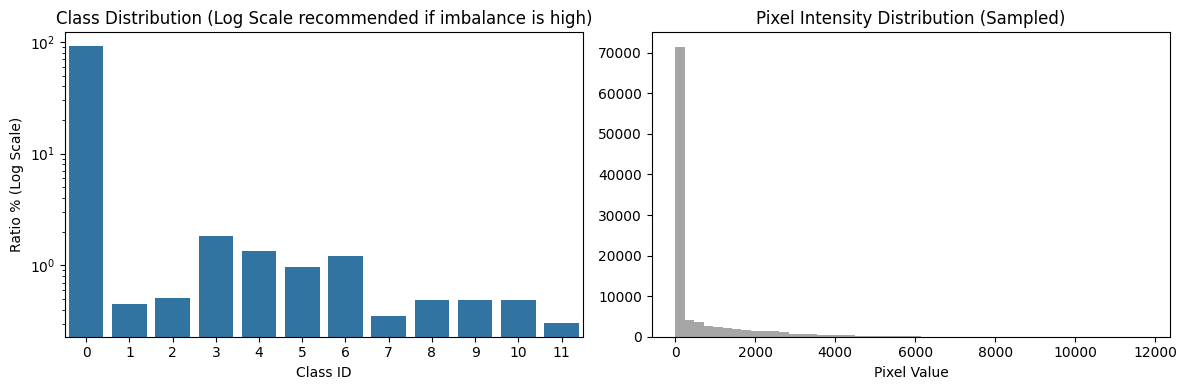

In [3]:
import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

# === 設定資料路徑 (請確認與你 Colab 的路徑一致) ===
DATASET_ROOT = './2D_dataset/2D_dataset'
TRAIN_DIR = os.path.join(DATASET_ROOT, 'train')
IMAGE_DIR = os.path.join(TRAIN_DIR, 'image')
LABEL_DIR = os.path.join(TRAIN_DIR, 'detailed_label')

# 定義詳細標籤名稱 (根據你的 PDF 資訊)
DETAILED_CLASSES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 7: 'Gracilis',
    8: 'Biceps Femoris (Long)', 9: 'Semitendinosus', 10: 'Semimembranosus', 11: 'Biceps Femoris (Short)'
}

def analyze_dataset():
    print("🔍 開始分析 Dataset 特性...\n")

    # 1. 取得檔案列表
    if not os.path.exists(LABEL_DIR):
        print(f"❌ 找不到路徑: {LABEL_DIR}")
        return

    label_files = sorted(glob.glob(os.path.join(LABEL_DIR, '*_detailed.nii.gz')))
    image_files = sorted(glob.glob(os.path.join(IMAGE_DIR, '*.nii.gz')))

    print(f"✅ 找到 {len(image_files)} 張影像")
    print(f"✅ 找到 {len(label_files)} 個標籤檔")

    if len(label_files) == 0: return

    # --- 分析 1: 檔名結構與病人 ID (Data Leakage Check) ---
    print("\n[1] 檔名結構範例 (前 5 筆):")
    patient_ids = set()
    for f in label_files[:5]:
        print("   -", os.path.basename(f))

    # 嘗試從檔名推測 Patient ID (假設格式通常包含 ID)
    # 這裡我們只做簡單統計，請你稍後把印出的檔名貼給我確認
    print("\n   (請稍後將上述檔名範例貼給我，我來確認如何切分 Train/Val)")

    # --- 分析 2: 類別像素統計 (Class Imbalance) ---
    print("\n[2] 正在計算類別分佈 (這可能需要幾分鐘)...")
    class_counts = {k: 0 for k in DETAILED_CLASSES.keys()}

    # 為了節省時間，隨機抽樣 500 張圖片進行統計 (若資料少則全跑)
    sample_size = min(len(label_files), 500)
    sample_files = np.random.choice(label_files, sample_size, replace=False)

    for lbl_path in tqdm(sample_files, desc="Scanning Labels"):
        nii = nib.load(lbl_path)
        mask = np.asanyarray(nii.dataobj)
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            if int(u) in class_counts:
                class_counts[int(u)] += c

    total_pixels = sum(class_counts.values())
    print("\n📊 類別像素佔比統計 (基於抽樣):")
    print(f"{'ID':<4} | {'Name':<25} | {'Pixel Count':<12} | {'Ratio (%)':<10}")
    print("-" * 60)

    df_data = []
    for cid, count in class_counts.items():
        ratio = (count / total_pixels) * 100
        name = DETAILED_CLASSES.get(cid, "Unknown")
        print(f"{cid:<4} | {name:<25} | {count:<12} | {ratio:.4f}%")
        df_data.append({"Class ID": cid, "Name": name, "Ratio": ratio, "Raw Count": count})

    # 建議：如果某個類別 < 0.5%，我們可能需要 Focal Loss

    # --- 分析 3: 影像強度分佈 (Normalization Check) ---
    print("\n[3] 正在分析影像強度 (Intensity)...")
    # 對應抽樣的 image
    pixel_values = []

    # 找出對應的 image path
    for lbl_path in sample_files[:100]: # 取前 100 張看分佈就好
        fname = os.path.basename(lbl_path).replace('_detailed.nii.gz', '.nii.gz')
        img_path = os.path.join(IMAGE_DIR, fname)
        if os.path.exists(img_path):
            nii = nib.load(img_path)
            img = np.asanyarray(nii.dataobj)
            # 簡單過濾掉全黑背景 (值為0)，只看有組織的部分
            valid_pixels = img[img > 0]
            if len(valid_pixels) > 0:
                # 為了避免記憶體爆掉，每張圖隨機取 1000 個點
                sampled_pixels = np.random.choice(valid_pixels, min(len(valid_pixels), 1000))
                pixel_values.extend(sampled_pixels)

    pixel_values = np.array(pixel_values)
    print(f"\n   影像像素統計 (非零區域):")
    print(f"   Min: {pixel_values.min():.2f}")
    print(f"   Max: {pixel_values.max():.2f}")
    print(f"   Mean: {pixel_values.mean():.2f}")
    print(f"   Std: {pixel_values.std():.2f}")

    # 畫圖
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.barplot(x="Class ID", y="Ratio", data=pd.DataFrame(df_data))
    plt.title("Class Distribution (Log Scale recommended if imbalance is high)")
    plt.yscale("log") # 用對數座標看清楚小類別
    plt.ylabel("Ratio % (Log Scale)")

    plt.subplot(1, 2, 2)
    plt.hist(pixel_values, bins=50, color='gray', alpha=0.7)
    plt.title("Pixel Intensity Distribution (Sampled)")
    plt.xlabel("Pixel Value")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_dataset()

In [4]:
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import cv2
import nibabel as nib
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# === 1. 設定參數與路徑 ===
DATASET_ROOT = './2D_dataset/2D_dataset'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
LR = 0.0003          # 稍微降低學習率以求穩定
EPOCHS = 30
IMG_SIZE = (256, 256)

# 對照表 (詳細 -> 粗略)
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

# === 2. 智慧型資料集劃分 (Patient-wise Split) ===
def get_split_files(root_dir, val_ratio=0.2, random_seed=42):
    """
    根據病人 ID (例如 THIGH_001) 進行切分，防止 Data Leakage。
    """
    image_dir = os.path.join(root_dir, 'train', 'image')
    detailed_dir = os.path.join(root_dir, 'train', 'detailed_label')

    # 取得所有標籤檔
    label_paths = sorted(glob.glob(os.path.join(detailed_dir, '*_detailed.nii.gz')))

    # 建立 Patient ID -> File List 的字典
    patient_map = {}
    valid_pairs = []

    print("正在依照病人 ID 進行分組...")
    for lbl_path in label_paths:
        filename = os.path.basename(lbl_path)

        # 嘗試解析 Patient ID (根據你的檔名：0_0_THIGH_001_Fat...)
        # 使用 Regex 抓取 "THIGH_數字"
        match = re.search(r"(THIGH_\d+)", filename)
        if match:
            pid = match.group(1)
        else:
            # 如果找不到規則，就退回到用前幾個字元分組 (Fallback)
            pid = "unknown"

        # 檢查對應的 Image 是否存在
        img_name = filename.replace('_detailed.nii.gz', '.nii.gz')
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            if pid not in patient_map:
                patient_map[pid] = []
            patient_map[pid].append((img_path, lbl_path))

    # 取得所有病人 ID 列表
    all_patients = list(patient_map.keys())
    train_pids, val_pids = train_test_split(all_patients, test_size=val_ratio, random_state=random_seed)

    train_files = []
    for pid in train_pids:
        train_files.extend(patient_map[pid])

    val_files = []
    for pid in val_pids:
        val_files.extend(patient_map[pid])

    print(f"✅ 總病人數: {len(all_patients)}")
    print(f"   Train Patients: {len(train_pids)} -> {len(train_files)} images")
    print(f"   Val Patients:   {len(val_pids)} -> {len(val_files)} images")

    return train_files, val_files

# === 3. 優化後的 Dataset (加入 Percentile Clipping) ===
class RobustThighDataset(Dataset):
    def __init__(self, file_pairs, target_size=(256, 256), augment=False):
        self.file_pairs = file_pairs
        self.target_size = target_size
        self.augment = augment # 預留擴增接口

    def __len__(self):
        return len(self.file_pairs)

    def preprocess_image(self, img):
        """
        優化版預處理：
        1. Percentile Clipping: 去除前 0.5% 極端亮點
        2. Min-Max Scaling
        """
        img = img.astype(np.float32)

        # Clipping: 避免 11790 這種極端值影響整體
        lower = np.percentile(img, 0.5)
        upper = np.percentile(img, 99.5)

        img = np.clip(img, lower, upper)

        # Normalize to 0-1
        if upper - lower > 0:
            img = (img - lower) / (upper - lower)
        else:
            img = img - lower # 避免除以零

        return img

    def resize_data(self, data, is_mask=False):
        method = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        return cv2.resize(data, self.target_size, interpolation=method)

    def __getitem__(self, idx):
        img_path, lbl_path = self.file_pairs[idx]

        try:
            # 讀取
            nii_img = nib.load(img_path)
            image_data = np.squeeze(nii_img.get_fdata())

            nii_lbl = nib.load(lbl_path)
            det_mask = np.squeeze(nii_lbl.get_fdata())

            # 預處理
            image_data = self.preprocess_image(image_data)
            image_data = self.resize_data(image_data, is_mask=False)

            det_mask = self.resize_data(det_mask, is_mask=True)

            # 產生 Rough Label
            rough_mask = np.zeros_like(det_mask)
            for d, r in ROUGH_MAPPING.items():
                rough_mask[det_mask == d] = r

            # 轉 Tensor
            # Image: (C, H, W) -> (3, 256, 256) for ResNet backbone
            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            det_tensor = torch.from_numpy(det_mask).long()
            rough_tensor = torch.from_numpy(rough_mask).long()

            return image_tensor, det_tensor, rough_tensor

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size).long(), torch.zeros(self.target_size).long()

# === 4. 模型定義 (保持不變) ===
class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder

        # Heads
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)   # 5類
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1) # 12類

    def forward(self, x):
        features = self.encoder(x)
        # Fix decoder args issue
        try:
            decoder_output = self.decoder(*features)
        except TypeError:
            decoder_output = self.decoder(features)

        out_rough = self.head_rough(decoder_output)
        out_detailed = self.head_detailed(decoder_output)
        return out_rough, out_detailed

# === 5. 訓練函式 (加入 Dice + Focal Loss) ===
def run_optimized_training():
    # 1. 準備檔案列表 (Patient-wise Split)
    train_files, val_files = get_split_files(DATASET_ROOT)

    # 2. 建立 Dataset & DataLoader
    train_ds = RobustThighDataset(train_files, target_size=IMG_SIZE, augment=True)
    val_ds = RobustThighDataset(val_files, target_size=IMG_SIZE, augment=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 3. 初始化模型
    model = MultiHeadUNet().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    # 4. 定義混合 Loss (Dice + Focal)
    # 這能有效解決 0.3% vs 91% 的不平衡問題
    dice_loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    focal_loss_fn = smp.losses.FocalLoss(mode='multiclass')

    # 記錄
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    print(f"\n🚀 Start Optimized Training on {DEVICE}...")

    for epoch in range(EPOCHS):
        # --- Train ---
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

        for imgs, det_masks, rough_masks in loop:
            imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

            optimizer.zero_grad()
            out_rough, out_detailed = model(imgs)

            # Loss 計算：Detailed 權重稍大一點，因為它比較難
            # Loss = Dice (形狀) + Focal (難易度)
            loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
            loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)

            loss = 0.6 * loss_det + 0.4 * loss_rough

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Val ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, det_masks, rough_masks in val_loader:
                imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

                out_rough, out_detailed = model(imgs)

                loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
                loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)
                loss = 0.6 * loss_det + 0.4 * loss_rough

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"   📊 Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # 儲存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_thigh_model_opt.pth')
            print("   💾 Best model saved!")

    print("✅ Training Complete.")
    return model

if __name__ == '__main__':
    # 執行訓練
    trained_model = run_optimized_training()

正在依照病人 ID 進行分組...
✅ 總病人數: 83
   Train Patients: 66 -> 4232 images
   Val Patients:   17 -> 1168 images


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


🚀 Start Optimized Training on cuda...


Epoch 1/30 [Train]: 100%|██████████| 265/265 [00:39<00:00,  6.75it/s, loss=1.43]


   📊 Train Loss: 1.8614 | Val Loss: 1.4280
   💾 Best model saved!


Epoch 2/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.12it/s, loss=1.01]


   📊 Train Loss: 1.1848 | Val Loss: 1.0105
   💾 Best model saved!


Epoch 3/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.07it/s, loss=0.849]


   📊 Train Loss: 0.9149 | Val Loss: 0.8411
   💾 Best model saved!


Epoch 4/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.661]


   📊 Train Loss: 0.7492 | Val Loss: 0.7006
   💾 Best model saved!


Epoch 5/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.01it/s, loss=0.506]


   📊 Train Loss: 0.5915 | Val Loss: 0.5794
   💾 Best model saved!


Epoch 6/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.337]


   📊 Train Loss: 0.4366 | Val Loss: 0.4181
   💾 Best model saved!


Epoch 7/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.236]


   📊 Train Loss: 0.2674 | Val Loss: 0.3191
   💾 Best model saved!


Epoch 8/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.198]


   📊 Train Loss: 0.1931 | Val Loss: 0.2896
   💾 Best model saved!


Epoch 9/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.173]


   📊 Train Loss: 0.1605 | Val Loss: 0.2800
   💾 Best model saved!


Epoch 10/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.142]


   📊 Train Loss: 0.1387 | Val Loss: 0.2660
   💾 Best model saved!


Epoch 11/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.118]


   📊 Train Loss: 0.1242 | Val Loss: 0.2723


Epoch 12/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.108]


   📊 Train Loss: 0.1141 | Val Loss: 0.2654
   💾 Best model saved!


Epoch 13/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.102]


   📊 Train Loss: 0.1054 | Val Loss: 0.2679


Epoch 14/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.105]


   📊 Train Loss: 0.0984 | Val Loss: 0.2621
   💾 Best model saved!


Epoch 15/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.97it/s, loss=0.0989]


   📊 Train Loss: 0.0928 | Val Loss: 0.2667


Epoch 16/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.117]


   📊 Train Loss: 0.0883 | Val Loss: 0.2636


Epoch 17/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.089]


   📊 Train Loss: 0.0838 | Val Loss: 0.2648


Epoch 18/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0666]


   📊 Train Loss: 0.0799 | Val Loss: 0.2624


Epoch 19/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  7.00it/s, loss=0.0767]


   📊 Train Loss: 0.0769 | Val Loss: 0.2678


Epoch 20/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0733]


   📊 Train Loss: 0.0735 | Val Loss: 0.2694


Epoch 21/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.079]


   📊 Train Loss: 0.0722 | Val Loss: 0.2667


Epoch 22/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0867]


   📊 Train Loss: 0.0695 | Val Loss: 0.2708


Epoch 23/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0734]


   📊 Train Loss: 0.0688 | Val Loss: 0.2724


Epoch 24/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.0681]


   📊 Train Loss: 0.0667 | Val Loss: 0.2760


Epoch 25/30 [Train]: 100%|██████████| 265/265 [00:38<00:00,  6.96it/s, loss=0.0764]


   📊 Train Loss: 0.0650 | Val Loss: 0.2773


Epoch 26/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0617]


   📊 Train Loss: 0.0626 | Val Loss: 0.2770


Epoch 27/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0625]


   📊 Train Loss: 0.0606 | Val Loss: 0.2752


Epoch 28/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0597]


   📊 Train Loss: 0.0594 | Val Loss: 0.2780


Epoch 29/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.98it/s, loss=0.0671]


   📊 Train Loss: 0.0577 | Val Loss: 0.2823


Epoch 30/30 [Train]: 100%|██████████| 265/265 [00:37<00:00,  6.99it/s, loss=0.0516]


   📊 Train Loss: 0.0571 | Val Loss: 0.2756
✅ Training Complete.


📂 正在載入模型權重: best_thigh_model_opt.pth ...
✅ 模型載入成功！
🔄 正在準備驗證集資料...
正在依照病人 ID 進行分組...
✅ 總病人數: 83
   Train Patients: 66 -> 4232 images
   Val Patients:   17 -> 1168 images
🚀 開始計算評估指標 (這可能需要一點時間)...


Evaluating: 100%|██████████| 1168/1168 [00:31<00:00, 37.28it/s]



🏆 最終驗證集評估報告 (Validation Set Report)
 Class ID            Muscle Name Dice Score IoU Score  Images Present
        0             Background     0.9897    0.9797            1168
        1              Sartorius     0.8060    0.6949            1168
        2         Rectus Femoris     0.6971    0.5987             952
        3       Vastus Lateralis     0.7747    0.6725            1133
        4     Vastus Intermedius     0.7331    0.6163            1117
        5        Vastus Medialis     0.7064    0.6060            1039
        6        Adductor Magnus     0.6132    0.5220             871
        7               Gracilis     0.7082    0.6114            1024
        8  Biceps Femoris (Long)     0.6185    0.5226             805
        9         Semitendinosus     0.6434    0.5388            1013
       10        Semimembranosus     0.6104    0.5067             838
       11 Biceps Femoris (Short)     0.6589    0.5528             702
-----------------------------------------------------

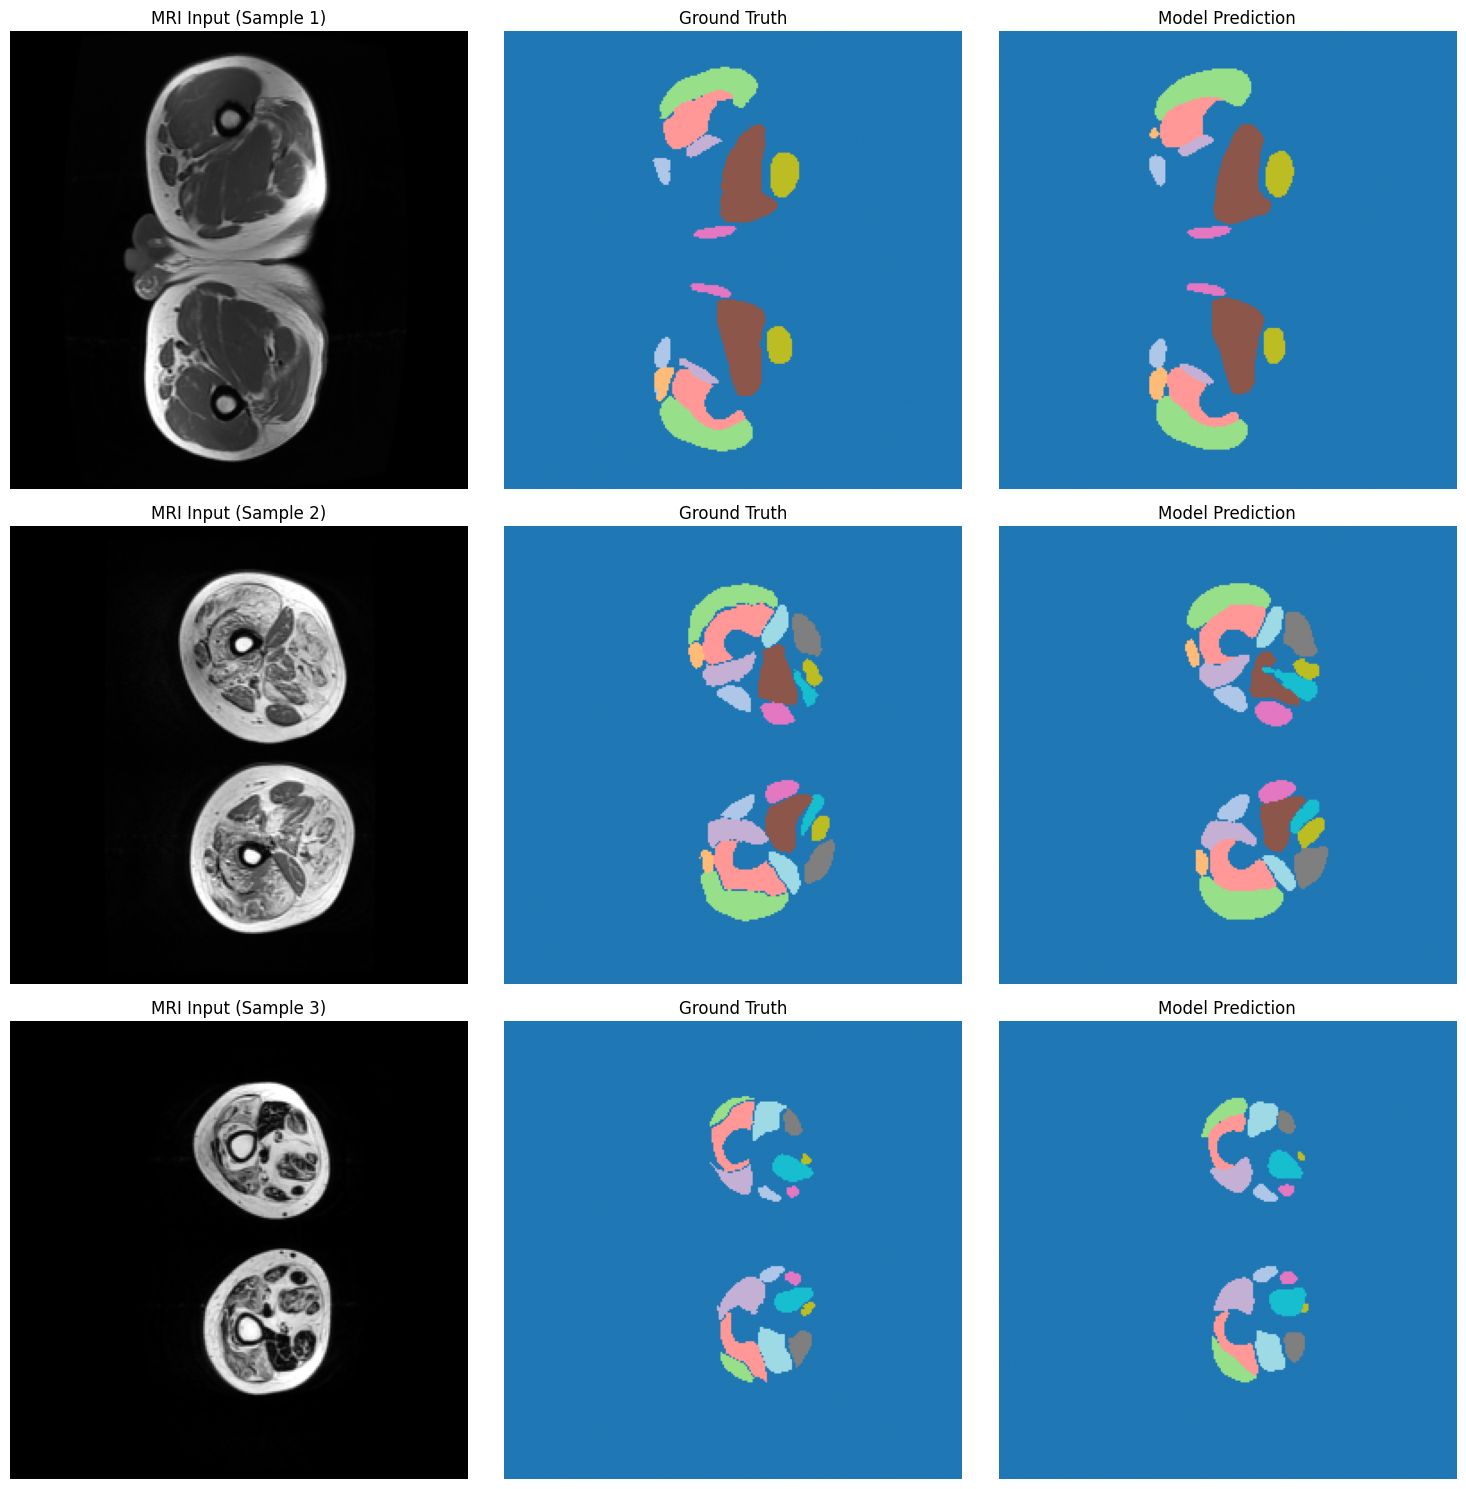

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# === 1. 定義評估指標計算函式 ===
def compute_class_metrics(pred_mask, true_mask, num_classes):
    """
    計算單張影像每個類別的 Dice 和 IoU
    """
    dice_scores = []
    iou_scores = []

    # 確保輸入在 CPU 上並轉為 numpy
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.cpu().numpy()

    for c in range(num_classes):
        p = (pred_mask == c)
        t = (true_mask == c)

        intersection = (p & t).sum()
        union = p.sum() + t.sum()

        # Dice
        if union == 0:
            dice = np.nan # 該圖片中不存在此類別，不計入平均
        else:
            dice = (2.0 * intersection) / (union + 1e-6)

        # IoU
        union_iou = p.sum() + t.sum() - intersection
        if union_iou == 0:
            iou = np.nan
        else:
            iou = intersection / (union_iou + 1e-6)

        dice_scores.append(dice)
        iou_scores.append(iou)

    return dice_scores, iou_scores

# === 2. 定義詳細類別名稱 (用於報表) ===
DETAILED_CLASSES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 7: 'Gracilis',
    8: 'Biceps Femoris (Long)', 9: 'Semitendinosus', 10: 'Semimembranosus', 11: 'Biceps Femoris (Short)'
}

# === 3. 主評估函式 ===
def evaluate_and_visualize(model_path='best_thigh_model_opt.pth'):
    print(f"📂 正在載入模型權重: {model_path} ...")

    # 1. 重新建立模型架構
    model = MultiHeadUNet().to(DEVICE)

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("✅ 模型載入成功！")
    else:
        print(f"❌ 錯誤：找不到模型檔案 {model_path}，請確認是否訓練完成。")
        return

    # 2. 取得驗證集資料 (使用與訓練相同的切分邏輯)
    # 注意：這裡假設 get_split_files 和 RobustThighDataset 已經在上一格定義過
    print("🔄 正在準備驗證集資料...")
    _, val_files = get_split_files(DATASET_ROOT, random_seed=42)
    val_ds = RobustThighDataset(val_files, target_size=IMG_SIZE, augment=False)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False) # Batch size 1 方便計算與繪圖

    model.eval()

    # 儲存分數
    class_dice_sums = {i: [] for i in range(12)}
    class_iou_sums = {i: [] for i in range(12)}

    print("🚀 開始計算評估指標 (這可能需要一點時間)...")

    with torch.no_grad():
        for imgs, det_masks, _ in tqdm(val_loader, desc="Evaluating"):
            imgs = imgs.to(DEVICE)
            det_masks = det_masks.to(DEVICE)

            # 推論
            _, out_detailed = model(imgs)
            pred_masks = torch.argmax(out_detailed, dim=1)

            # 計算指標
            d_scores, i_scores = compute_class_metrics(pred_masks, det_masks, 12)

            for cls_idx in range(12):
                if not np.isnan(d_scores[cls_idx]):
                    class_dice_sums[cls_idx].append(d_scores[cls_idx])
                    class_iou_sums[cls_idx].append(i_scores[cls_idx])

    # === 4. 產生報表 ===
    print("\n" + "="*60)
    print("🏆 最終驗證集評估報告 (Validation Set Report)")
    print("="*60)

    report_data = []
    for cls_idx in range(12):
        name = DETAILED_CLASSES[cls_idx]
        mean_dice = np.mean(class_dice_sums[cls_idx]) if class_dice_sums[cls_idx] else 0.0
        mean_iou = np.mean(class_iou_sums[cls_idx]) if class_iou_sums[cls_idx] else 0.0
        count = len(class_dice_sums[cls_idx]) # 該類別出現的圖片張數

        report_data.append({
            "Class ID": cls_idx,
            "Muscle Name": name,
            "Dice Score": mean_dice,
            "IoU Score": mean_iou,
            "Images Present": count
        })

    df = pd.DataFrame(report_data)
    # 計算平均 (排除背景)
    avg_muscle_dice = df.loc[1:, "Dice Score"].mean()
    avg_muscle_iou = df.loc[1:, "IoU Score"].mean()

    print(df.to_string(index=False, formatters={"Dice Score": "{:.4f}".format, "IoU Score": "{:.4f}".format}))
    print("-" * 60)
    print(f"🔥 Average Muscle Dice: {avg_muscle_dice:.4f}")
    print(f"🔥 Average Muscle IoU : {avg_muscle_iou:.4f}")
    print("="*60 + "\n")

    # === 5. 視覺化結果 (隨機抽 3 張) ===
    print("🎨 正在繪製預測結果範例...")
    visualize_loader = DataLoader(val_ds, batch_size=1, shuffle=True) # Shuffle=True 隨機抽

    num_show = 3
    fig, axes = plt.subplots(num_show, 3, figsize=(15, 5 * num_show))

    with torch.no_grad():
        for i, (img, gt, _) in enumerate(visualize_loader):
            if i >= num_show: break

            img = img.to(DEVICE)
            _, out_detailed = model(img)
            pred = torch.argmax(out_detailed, dim=1).squeeze().cpu().numpy()

            # 處理影像顯示 (C, H, W) -> (H, W, C)
            img_vis = img.squeeze().permute(1, 2, 0).cpu().numpy()
            # 因為我們做了 normalization，這裡稍微調整對比度以便觀看
            img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

            gt_vis = gt.squeeze().numpy()

            # 設定 colormap
            cmap = 'tab20' # 適合多類別

            # 繪圖
            # 1. Input MRI
            ax = axes[i, 0] if num_show > 1 else axes[0]
            ax.imshow(img_vis, cmap='gray')
            ax.set_title(f"MRI Input (Sample {i+1})")
            ax.axis('off')

            # 2. Ground Truth
            ax = axes[i, 1] if num_show > 1 else axes[1]
            ax.imshow(gt_vis, cmap=cmap, vmin=0, vmax=11)
            ax.set_title("Ground Truth")
            ax.axis('off')

            # 3. Prediction
            ax = axes[i, 2] if num_show > 1 else axes[2]
            ax.imshow(pred, cmap=cmap, vmin=0, vmax=11)
            ax.set_title("Model Prediction")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# === 執行評估 ===
if __name__ == '__main__':
    evaluate_and_visualize()

In [7]:
# ==========================================
# 1. 安裝必要的套件
# ==========================================
import sys
import subprocess

def install_packages():
    packages = [
        "nibabel", "matplotlib", "opencv-python",
        "segmentation-models-pytorch", "albumentations", "pandas", "tqdm"
    ]
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("⏳ 正在安裝必要套件...")
install_packages()
print("✅ 套件安裝完成。")

# ==========================================
# 2. 匯入函式庫
# ==========================================
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ==========================================
# 3. 全域參數設定
# ==========================================
DATASET_ROOT = './2D_dataset/2D_dataset'  # 請確認你的資料路徑
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
LR = 0.0003
EPOCHS = 30
IMG_SIZE = (256, 256)

# 肌肉類別定義
DETAILED_CLASSES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 7: 'Gracilis',
    8: 'Biceps Femoris (Long)', 9: 'Semitendinosus', 10: 'Semimembranosus', 11: 'Biceps Femoris (Short)'
}

# 粗略分類映射
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

print(f"✅ 參數設定完成。使用裝置: {DEVICE}")

# ==========================================
# 4. 資料增強管線 (Data Augmentation)
# ==========================================
def get_training_augmentation():
    train_transform = [
        # 幾何變換
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        # 彈性變形 (模擬肌肉擠壓)
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        # 亮度與對比度 (模擬 MRI 機器差異)
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        # 雜訊
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.GridDistortion(p=0.2),
    ]
    return A.Compose(train_transform)

# ==========================================
# 5. 資料集類別 (Dataset Class)
# ==========================================
class AugmentedThighDataset(Dataset):
    def __init__(self, file_pairs, target_size=(256, 256), transform=None):
        self.file_pairs = file_pairs
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.file_pairs)

    def preprocess_image(self, img):
        """
        99.5% Percentile Clipping + MinMax Normalization
        """
        img = img.astype(np.float32)
        lower = np.percentile(img, 0.5)
        upper = np.percentile(img, 99.5)
        img = np.clip(img, lower, upper)

        if upper - lower > 0:
            img = (img - lower) / (upper - lower)
        else:
            img = img - lower
        return img

    def __getitem__(self, idx):
        img_path, lbl_path = self.file_pairs[idx]

        try:
            # 1. 讀取 NIfTI
            nii_img = nib.load(img_path)
            image_data = np.squeeze(nii_img.get_fdata())
            nii_lbl = nib.load(lbl_path)
            det_mask = np.squeeze(nii_lbl.get_fdata())

            # 2. 影像預處理
            image_data = self.preprocess_image(image_data)

            # 3. 調整大小
            image_data = cv2.resize(image_data, self.target_size, interpolation=cv2.INTER_LINEAR)
            det_mask = cv2.resize(det_mask, self.target_size, interpolation=cv2.INTER_NEAREST)

            # 4. 資料增強
            if self.transform:
                # Albumentations 增強
                augmented = self.transform(image=image_data, mask=det_mask)
                image_data = augmented['image']
                det_mask = augmented['mask']

            # 5. 產生 Rough Mask (必須在增強後產生，確保位置一致)
            rough_mask = np.zeros_like(det_mask)
            for d, r in ROUGH_MAPPING.items():
                rough_mask[det_mask == d] = r

            # 6. 轉 Tensor (C, H, W)
            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            det_tensor = torch.from_numpy(det_mask).long()
            rough_tensor = torch.from_numpy(rough_mask).long()

            return image_tensor, det_tensor, rough_tensor

        except Exception as e:
            print(f"Error loading {os.path.basename(img_path)}: {e}")
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size).long(), torch.zeros(self.target_size).long()

# ==========================================
# 6. 資料切分 (Patient-wise Split)
# ==========================================
def get_split_files(root_dir, val_ratio=0.2, random_seed=42):
    image_dir = os.path.join(root_dir, 'train', 'image')
    detailed_dir = os.path.join(root_dir, 'train', 'detailed_label')

    if not os.path.exists(detailed_dir):
        print(f"❌ 找不到路徑: {detailed_dir}")
        return [], []

    label_paths = sorted(glob.glob(os.path.join(detailed_dir, '*_detailed.nii.gz')))
    patient_map = {}

    print("🔍 正在依照病人 ID 進行分組 (防止 Data Leakage)...")
    for lbl_path in label_paths:
        filename = os.path.basename(lbl_path)
        match = re.search(r"(THIGH_\d+)", filename)
        pid = match.group(1) if match else "unknown"

        img_name = filename.replace('_detailed.nii.gz', '.nii.gz')
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            if pid not in patient_map: patient_map[pid] = []
            patient_map[pid].append((img_path, lbl_path))

    all_patients = list(patient_map.keys())
    train_pids, val_pids = train_test_split(all_patients, test_size=val_ratio, random_state=random_seed)

    train_files, val_files = [], []
    for pid in train_pids: train_files.extend(patient_map[pid])
    for pid in val_pids: val_files.extend(patient_map[pid])

    print(f"✅ 資料分組完成! Train Patients: {len(train_pids)} | Val Patients: {len(val_pids)}")
    print(f"   Train Images: {len(train_files)} | Val Images: {len(val_files)}")
    return train_files, val_files

# ==========================================
# 7. 模型定義 (Multi-Head U-Net)
# ==========================================
class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1)

    def forward(self, x):
        features = self.encoder(x)
        try: decoder_output = self.decoder(*features)
        except TypeError: decoder_output = self.decoder(features)
        return self.head_rough(decoder_output), self.head_detailed(decoder_output)

# ==========================================
# 8. 評估指標函式
# ==========================================
def compute_class_metrics(pred_mask, true_mask, num_classes):
    dice_scores, iou_scores = [], []
    if isinstance(pred_mask, torch.Tensor): pred_mask = pred_mask.cpu().numpy()
    if isinstance(true_mask, torch.Tensor): true_mask = true_mask.cpu().numpy()

    for c in range(num_classes):
        p, t = (pred_mask == c), (true_mask == c)
        intersection, union = (p & t).sum(), p.sum() + t.sum()

        if union == 0:
            dice = np.nan
        else:
            dice = (2.0 * intersection) / (union + 1e-6)

        union_iou = p.sum() + t.sum() - intersection
        iou = np.nan if union_iou == 0 else intersection / (union_iou + 1e-6)

        dice_scores.append(dice)
        iou_scores.append(iou)
    return dice_scores, iou_scores

# ==========================================
# 9. 主訓練與評估函式
# ==========================================
def run_full_pipeline():
    # --- 步驟 1: 準備資料 ---
    train_files, val_files = get_split_files(DATASET_ROOT)
    if not train_files: return

    # 訓練集套用增強，驗證集不套用
    train_ds = AugmentedThighDataset(train_files, target_size=IMG_SIZE, transform=get_training_augmentation())
    val_ds = AugmentedThighDataset(val_files, target_size=IMG_SIZE, transform=None)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- 步驟 2: 初始化模型 ---
    model = MultiHeadUNet().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    # 排程器：當 Val Loss 卡住 5 個 Epoch，LR 減半
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    # Loss: Dice + Focal
    dice_loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    focal_loss_fn = smp.losses.FocalLoss(mode='multiclass')

    print(f"\n🚀 開始訓練 (共 {EPOCHS} Epochs)...")
    best_dice = 0.0
    save_path = 'best_thigh_model_final.pth'

    # --- 步驟 3: 訓練迴圈 ---
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for imgs, det_masks, rough_masks in loop:
            imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

            optimizer.zero_grad()
            out_rough, out_detailed = model(imgs)

            # Loss 計算
            loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
            loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)
            loss = 0.6 * loss_det + 0.4 * loss_rough

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # --- 步驟 4: 驗證與評分 ---
        model.eval()
        val_loss = 0
        class_dice_sums = {i: [] for i in range(12)}

        with torch.no_grad():
            for imgs, det_masks, rough_masks in val_loader:
                imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)
                out_rough, out_detailed = model(imgs)

                loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
                loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)
                val_loss += (0.6 * loss_det + 0.4 * loss_rough).item()

                pred_labels = torch.argmax(out_detailed, dim=1)
                for i in range(len(pred_labels)):
                    d_scores, _ = compute_class_metrics(pred_labels[i], det_masks[i], 12)
                    for cls_idx, score in enumerate(d_scores):
                        if not np.isnan(score): class_dice_sums[cls_idx].append(score)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # 計算平均 Muscle Dice (排除背景)
        mean_dice_per_class = [np.mean(scores) if scores else 0.0 for i, scores in class_dice_sums.items()]
        avg_muscle_dice = np.mean(mean_dice_per_class[1:])

        # 更新 Scheduler
        scheduler.step(avg_val_loss)

        print(f"   📊 Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Muscle Dice: {avg_muscle_dice:.4f}")

        if avg_muscle_dice > best_dice:
            best_dice = avg_muscle_dice
            torch.save(model.state_dict(), save_path)
            print("   💾 Best Dice Reached! Model Saved.")

    # --- 步驟 5: 最終報告 ---
    print("\n" + "="*60)
    print("🏆 最終驗證集詳細評估報告")
    print("="*60)

    report_data = []
    for cls_idx in range(12):
        name = DETAILED_CLASSES[cls_idx]
        score = np.mean(class_dice_sums[cls_idx]) if class_dice_sums[cls_idx] else 0.0
        report_data.append({"Class ID": cls_idx, "Muscle Name": name, "Dice Score": score})

    df = pd.DataFrame(report_data)
    print(df.to_string(index=False, formatters={"Dice Score": "{:.4f}".format}))
    print("-" * 60)
    print(f"🔥 Final Average Muscle Dice: {avg_muscle_dice:.4f}")

    # --- 步驟 6: 視覺化 ---
    print("\n🎨 繪製預測結果範例...")
    visualize_loader = DataLoader(val_ds, batch_size=1, shuffle=True)
    num_show = 3
    fig, axes = plt.subplots(num_show, 3, figsize=(15, 5 * num_show))

    model.load_state_dict(torch.load(save_path))
    model.eval()

    with torch.no_grad():
        for i, (img, gt, _) in enumerate(visualize_loader):
            if i >= num_show: break

            img_gpu = img.to(DEVICE)
            _, out_detailed = model(img_gpu)
            pred = torch.argmax(out_detailed, dim=1).squeeze().cpu().numpy()

            img_vis = img.squeeze().permute(1, 2, 0).cpu().numpy()
            img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

            gt_vis = gt.squeeze().numpy()

            ax = axes[i, 0] if num_show > 1 else axes[0]
            ax.imshow(img_vis, cmap='gray')
            ax.set_title(f"MRI Input {i+1}")
            ax.axis('off')

            ax = axes[i, 1] if num_show > 1 else axes[1]
            ax.imshow(gt_vis, cmap='tab20', vmin=0, vmax=11)
            ax.set_title("Ground Truth")
            ax.axis('off')

            ax = axes[i, 2] if num_show > 1 else axes[2]
            ax.imshow(pred, cmap='tab20', vmin=0, vmax=11)
            ax.set_title("Prediction")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# ==========================================
# 10. 執行主程式
# ==========================================
if __name__ == '__main__':
    if os.path.exists(DATASET_ROOT):
        run_full_pipeline()
    else:
        print(f"❌ 找不到資料集路徑 {DATASET_ROOT}")
        print("請確認 Google Drive 是否已掛載或資料是否已解壓縮。")

⏳ 正在安裝必要套件...
✅ 套件安裝完成。
✅ 參數設定完成。使用裝置: cuda
🔍 正在依照病人 ID 進行分組 (防止 Data Leakage)...
✅ 資料分組完成! Train Patients: 66 | Val Patients: 17
   Train Images: 4232 | Val Images: 1168


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-4281189139.py:74: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2, border_mode=cv2.BORDER_CONSTANT),
/tmp/ipython-input-4281189139.py:78: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

⏳ 正在安裝必要套件...
✅ 套件安裝完成。
✅ 參數設定完成。使用裝置: cuda
🔍 正在依照病人 ID 進行分組 (防止 Data Leakage)...
✅ 資料分組完成! Train Patients: 66 | Val Patients: 17
   Train Images: 4232 | Val Images: 1168


/tmp/ipython-input-776545183.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),



🚀 開始訓練 (共 30 Epochs)...


Epoch 1/30: 100%|██████████| 265/265 [00:44<00:00,  5.94it/s, loss=1.55]


   📊 Train Loss: 2.0213 | Val Loss: 1.5234 | Muscle Dice: 0.0127 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 2/30: 100%|██████████| 265/265 [00:44<00:00,  5.90it/s, loss=1.08]


   📊 Train Loss: 1.2748 | Val Loss: 1.0759 | Muscle Dice: 0.0576 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 3/30: 100%|██████████| 265/265 [00:44<00:00,  5.91it/s, loss=0.89]


   📊 Train Loss: 0.9836 | Val Loss: 0.8862 | Muscle Dice: 0.2110 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 4/30: 100%|██████████| 265/265 [00:44<00:00,  5.92it/s, loss=0.759]


   📊 Train Loss: 0.8249 | Val Loss: 0.7602 | Muscle Dice: 0.3029 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 5/30: 100%|██████████| 265/265 [00:44<00:00,  5.90it/s, loss=0.63]


   📊 Train Loss: 0.6883 | Val Loss: 0.5991 | Muscle Dice: 0.4445 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 6/30: 100%|██████████| 265/265 [00:45<00:00,  5.82it/s, loss=0.401]


   📊 Train Loss: 0.5082 | Val Loss: 0.4320 | Muscle Dice: 0.6172 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 7/30: 100%|██████████| 265/265 [00:44<00:00,  5.90it/s, loss=0.324]


   📊 Train Loss: 0.3652 | Val Loss: 0.3476 | Muscle Dice: 0.6345 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 8/30: 100%|██████████| 265/265 [00:45<00:00,  5.87it/s, loss=0.326]


   📊 Train Loss: 0.3005 | Val Loss: 0.2982 | Muscle Dice: 0.6680 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 9/30: 100%|██████████| 265/265 [00:44<00:00,  5.89it/s, loss=0.268]


   📊 Train Loss: 0.2708 | Val Loss: 0.2782 | Muscle Dice: 0.6714 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 10/30: 100%|██████████| 265/265 [00:45<00:00,  5.89it/s, loss=0.255]


   📊 Train Loss: 0.2522 | Val Loss: 0.2578 | Muscle Dice: 0.6956 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 11/30: 100%|██████████| 265/265 [00:45<00:00,  5.88it/s, loss=0.198]


   📊 Train Loss: 0.2387 | Val Loss: 0.2412 | Muscle Dice: 0.7087 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 12/30: 100%|██████████| 265/265 [00:44<00:00,  5.90it/s, loss=0.216]


   📊 Train Loss: 0.2303 | Val Loss: 0.2388 | Muscle Dice: 0.7028 | LR: 0.000300


Epoch 13/30: 100%|██████████| 265/265 [00:44<00:00,  5.90it/s, loss=0.229]


   📊 Train Loss: 0.2227 | Val Loss: 0.2296 | Muscle Dice: 0.7115 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 14/30: 100%|██████████| 265/265 [00:44<00:00,  5.99it/s, loss=0.189]


   📊 Train Loss: 0.2183 | Val Loss: 0.2286 | Muscle Dice: 0.7124 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 15/30: 100%|██████████| 265/265 [00:45<00:00,  5.81it/s, loss=0.19]


   📊 Train Loss: 0.2109 | Val Loss: 0.2312 | Muscle Dice: 0.7094 | LR: 0.000300


Epoch 16/30: 100%|██████████| 265/265 [00:45<00:00,  5.83it/s, loss=0.208]


   📊 Train Loss: 0.2072 | Val Loss: 0.2267 | Muscle Dice: 0.7109 | LR: 0.000300


Epoch 17/30: 100%|██████████| 265/265 [00:45<00:00,  5.79it/s, loss=0.214]


   📊 Train Loss: 0.2037 | Val Loss: 0.2254 | Muscle Dice: 0.7146 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 18/30: 100%|██████████| 265/265 [00:46<00:00,  5.73it/s, loss=0.2]


   📊 Train Loss: 0.1999 | Val Loss: 0.2257 | Muscle Dice: 0.7128 | LR: 0.000300


Epoch 19/30: 100%|██████████| 265/265 [00:45<00:00,  5.78it/s, loss=0.184]


   📊 Train Loss: 0.1963 | Val Loss: 0.2194 | Muscle Dice: 0.7192 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 20/30: 100%|██████████| 265/265 [00:44<00:00,  5.90it/s, loss=0.215]


   📊 Train Loss: 0.1942 | Val Loss: 0.2230 | Muscle Dice: 0.7177 | LR: 0.000300


Epoch 21/30: 100%|██████████| 265/265 [00:44<00:00,  5.92it/s, loss=0.176]


   📊 Train Loss: 0.1930 | Val Loss: 0.2228 | Muscle Dice: 0.7167 | LR: 0.000300


Epoch 22/30: 100%|██████████| 265/265 [00:45<00:00,  5.81it/s, loss=0.181]


   📊 Train Loss: 0.1906 | Val Loss: 0.2180 | Muscle Dice: 0.7198 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 23/30: 100%|██████████| 265/265 [00:45<00:00,  5.83it/s, loss=0.197]


   📊 Train Loss: 0.1949 | Val Loss: 0.2181 | Muscle Dice: 0.7168 | LR: 0.000300


Epoch 24/30: 100%|██████████| 265/265 [00:44<00:00,  5.91it/s, loss=0.255]


   📊 Train Loss: 0.1900 | Val Loss: 0.2193 | Muscle Dice: 0.7212 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 25/30: 100%|██████████| 265/265 [00:44<00:00,  5.93it/s, loss=0.194]


   📊 Train Loss: 0.1862 | Val Loss: 0.2166 | Muscle Dice: 0.7203 | LR: 0.000300


Epoch 26/30: 100%|██████████| 265/265 [00:45<00:00,  5.85it/s, loss=0.165]


   📊 Train Loss: 0.1809 | Val Loss: 0.2144 | Muscle Dice: 0.7250 | LR: 0.000300
   💾 Best Dice Reached! Model Saved.


Epoch 27/30: 100%|██████████| 265/265 [00:44<00:00,  5.92it/s, loss=0.162]


   📊 Train Loss: 0.1819 | Val Loss: 0.2197 | Muscle Dice: 0.7196 | LR: 0.000300


Epoch 28/30: 100%|██████████| 265/265 [00:45<00:00,  5.86it/s, loss=0.183]


   📊 Train Loss: 0.1806 | Val Loss: 0.2164 | Muscle Dice: 0.7188 | LR: 0.000300


Epoch 29/30: 100%|██████████| 265/265 [00:44<00:00,  5.91it/s, loss=0.178]


   📊 Train Loss: 0.1800 | Val Loss: 0.2178 | Muscle Dice: 0.7196 | LR: 0.000300


Epoch 30/30: 100%|██████████| 265/265 [00:45<00:00,  5.84it/s, loss=0.21]


   📊 Train Loss: 0.1782 | Val Loss: 0.2174 | Muscle Dice: 0.7218 | LR: 0.000300

🏆 最終驗證集詳細評估報告
 Class ID            Muscle Name Dice Score
        0             Background     0.9904
        1              Sartorius     0.8208
        2         Rectus Femoris     0.7430
        3       Vastus Lateralis     0.7931
        4     Vastus Intermedius     0.7316
        5        Vastus Medialis     0.7175
        6        Adductor Magnus     0.6525
        7               Gracilis     0.7427
        8  Biceps Femoris (Long)     0.6752
        9         Semitendinosus     0.6729
       10        Semimembranosus     0.6522
       11 Biceps Femoris (Short)     0.7379
------------------------------------------------------------
🔥 Final Average Muscle Dice: 0.7218

🎨 繪製預測結果範例...


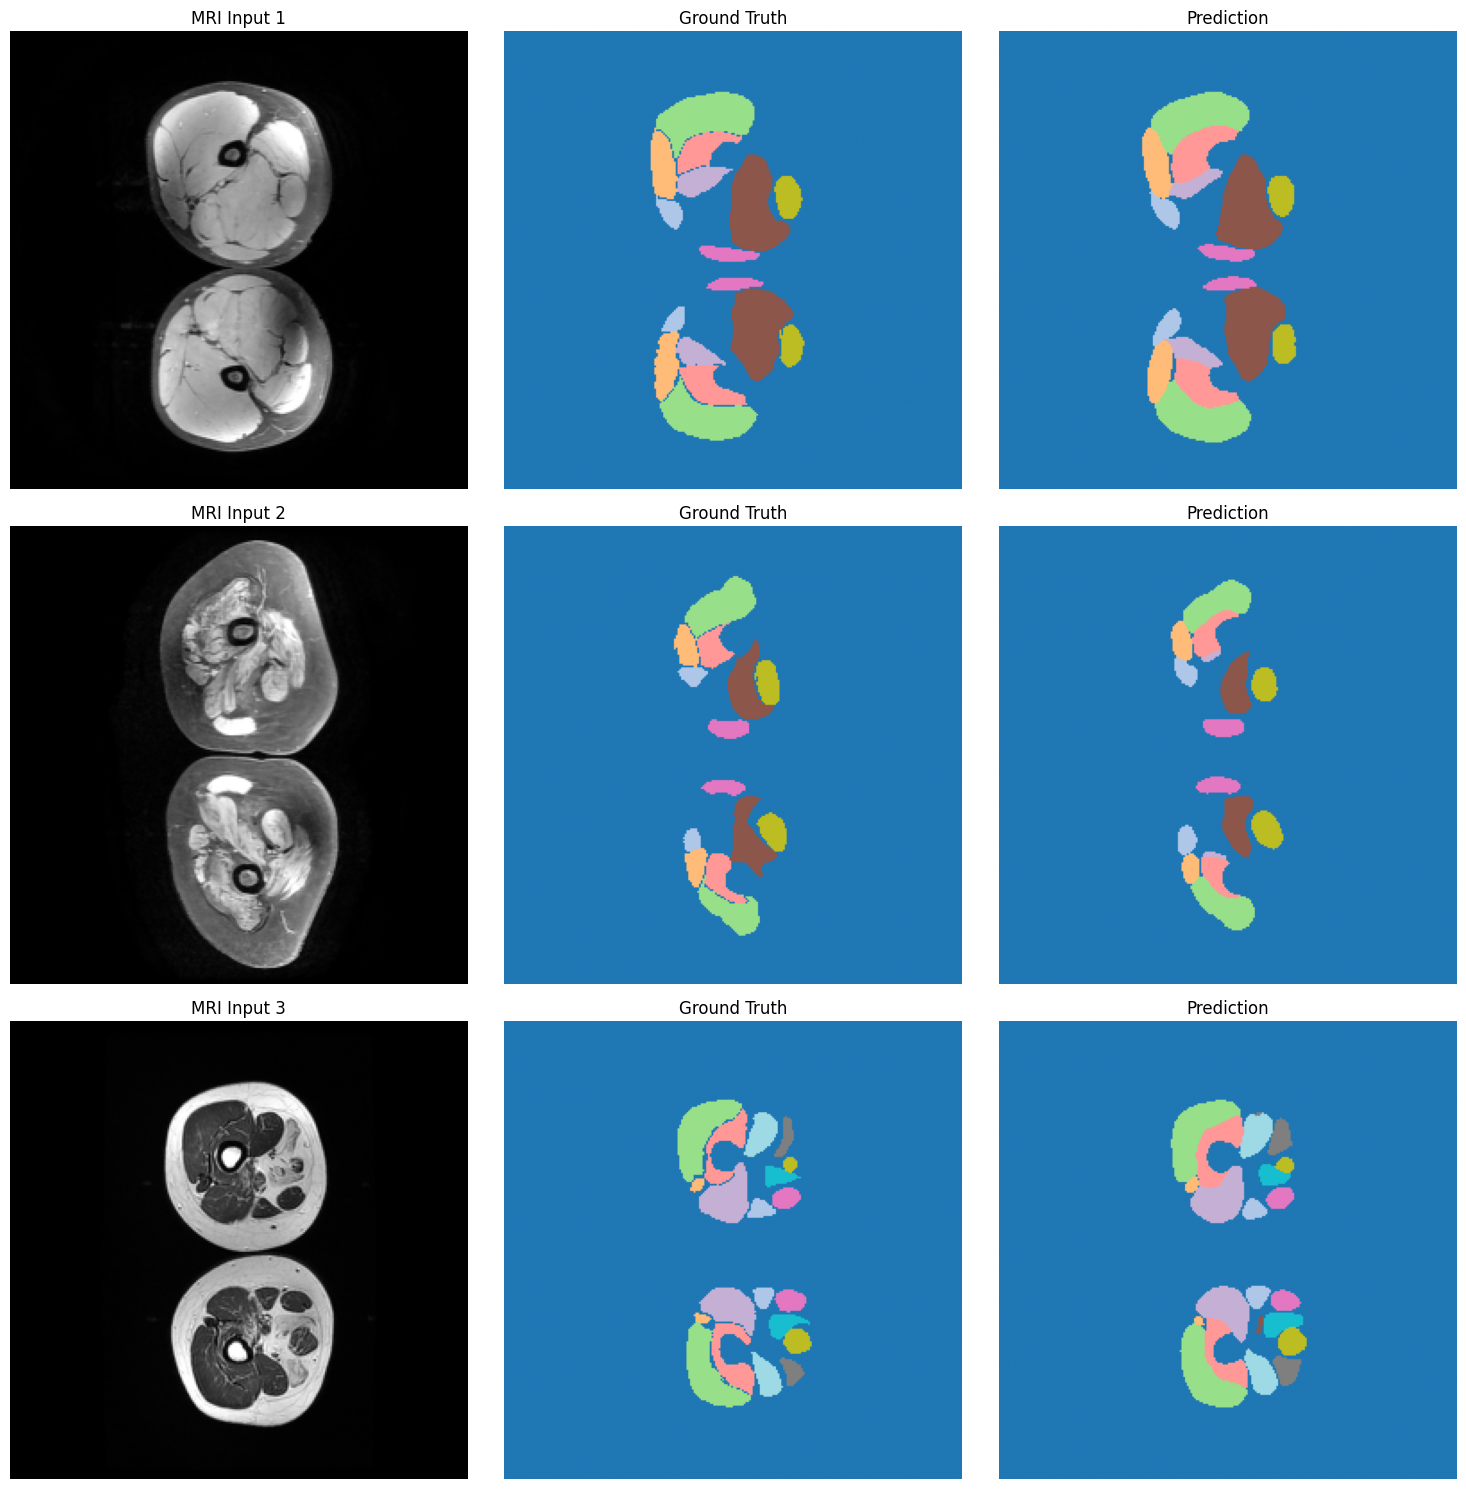

In [9]:
# ==========================================
# 1. 安裝必要的套件
# ==========================================
import sys
import subprocess

def install_packages():
    packages = [
        "nibabel", "matplotlib", "opencv-python",
        "segmentation-models-pytorch", "albumentations", "pandas", "tqdm"
    ]
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("⏳ 正在安裝必要套件...")
install_packages()
print("✅ 套件安裝完成。")

# ==========================================
# 2. 匯入函式庫
# ==========================================
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ==========================================
# 3. 全域參數設定
# ==========================================
DATASET_ROOT = './2D_dataset/2D_dataset'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
LR = 0.0003
EPOCHS = 30
IMG_SIZE = (256, 256)

# 肌肉類別定義
DETAILED_CLASSES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 7: 'Gracilis',
    8: 'Biceps Femoris (Long)', 9: 'Semitendinosus', 10: 'Semimembranosus', 11: 'Biceps Femoris (Short)'
}

# 粗略分類映射
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

print(f"✅ 參數設定完成。使用裝置: {DEVICE}")

# ==========================================
# 4. 資料增強管線 (Data Augmentation) - 修正版
# ==========================================
def get_training_augmentation():
    train_transform = [
        # 幾何變換
        A.HorizontalFlip(p=0.5),
        # 使用 Affine 替代 ShiftScaleRotate 以符合新版 API 建議 (或保留 ShiftScaleRotate 忽略警告)
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),

        # 彈性變形 (修正：移除 alpha_affine 參數)
        A.ElasticTransform(alpha=1, sigma=50, p=0.2, border_mode=cv2.BORDER_CONSTANT),

        # 亮度與對比度
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

        # 雜訊
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.GridDistortion(p=0.2),
    ]
    return A.Compose(train_transform)

# ==========================================
# 5. 資料集類別 (Dataset Class)
# ==========================================
class AugmentedThighDataset(Dataset):
    def __init__(self, file_pairs, target_size=(256, 256), transform=None):
        self.file_pairs = file_pairs
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.file_pairs)

    def preprocess_image(self, img):
        """
        99.5% Percentile Clipping + MinMax Normalization
        """
        img = img.astype(np.float32)
        # 簡單防呆：避免全黑圖造成錯誤
        if img.size > 0 and img.max() > 0:
            lower = np.percentile(img, 0.5)
            upper = np.percentile(img, 99.5)
            img = np.clip(img, lower, upper)
            if upper - lower > 0:
                img = (img - lower) / (upper - lower)
            else:
                img = img - lower
        return img

    def __getitem__(self, idx):
        img_path, lbl_path = self.file_pairs[idx]

        try:
            # 1. 讀取 NIfTI
            nii_img = nib.load(img_path)
            image_data = np.squeeze(nii_img.get_fdata())
            nii_lbl = nib.load(lbl_path)
            det_mask = np.squeeze(nii_lbl.get_fdata())

            # 2. 影像預處理
            image_data = self.preprocess_image(image_data)

            # 3. 調整大小
            image_data = cv2.resize(image_data, self.target_size, interpolation=cv2.INTER_LINEAR)
            det_mask = cv2.resize(det_mask, self.target_size, interpolation=cv2.INTER_NEAREST)

            # 4. 資料增強
            if self.transform:
                # Albumentations 增強
                augmented = self.transform(image=image_data, mask=det_mask)
                image_data = augmented['image']
                det_mask = augmented['mask']

            # 5. 產生 Rough Mask
            rough_mask = np.zeros_like(det_mask)
            for d, r in ROUGH_MAPPING.items():
                rough_mask[det_mask == d] = r

            # 6. 轉 Tensor (C, H, W)
            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            det_tensor = torch.from_numpy(det_mask).long()
            rough_tensor = torch.from_numpy(rough_mask).long()

            return image_tensor, det_tensor, rough_tensor

        except Exception as e:
            print(f"Error loading {os.path.basename(img_path)}: {e}")
            # 回傳空資料避免中斷
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size).long(), torch.zeros(self.target_size).long()

# ==========================================
# 6. 資料切分 (Patient-wise Split)
# ==========================================
def get_split_files(root_dir, val_ratio=0.2, random_seed=42):
    image_dir = os.path.join(root_dir, 'train', 'image')
    detailed_dir = os.path.join(root_dir, 'train', 'detailed_label')

    if not os.path.exists(detailed_dir):
        print(f"❌ 找不到路徑: {detailed_dir}")
        return [], []

    label_paths = sorted(glob.glob(os.path.join(detailed_dir, '*_detailed.nii.gz')))
    patient_map = {}

    print("🔍 正在依照病人 ID 進行分組 (防止 Data Leakage)...")
    for lbl_path in label_paths:
        filename = os.path.basename(lbl_path)
        # 使用 Regex 抓取 ID
        match = re.search(r"(THIGH_\d+)", filename)
        pid = match.group(1) if match else "unknown"

        img_name = filename.replace('_detailed.nii.gz', '.nii.gz')
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            if pid not in patient_map: patient_map[pid] = []
            patient_map[pid].append((img_path, lbl_path))

    all_patients = list(patient_map.keys())
    if not all_patients:
        print("❌ 找不到任何病人資料！")
        return [], []

    train_pids, val_pids = train_test_split(all_patients, test_size=val_ratio, random_state=random_seed)

    train_files, val_files = [], []
    for pid in train_pids: train_files.extend(patient_map[pid])
    for pid in val_pids: val_files.extend(patient_map[pid])

    print(f"✅ 資料分組完成! Train Patients: {len(train_pids)} | Val Patients: {len(val_pids)}")
    print(f"   Train Images: {len(train_files)} | Val Images: {len(val_files)}")
    return train_files, val_files

# ==========================================
# 7. 模型定義 (Multi-Head U-Net)
# ==========================================
class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1)

    def forward(self, x):
        features = self.encoder(x)
        try: decoder_output = self.decoder(*features)
        except TypeError: decoder_output = self.decoder(features)
        return self.head_rough(decoder_output), self.head_detailed(decoder_output)

# ==========================================
# 8. 評估指標函式
# ==========================================
def compute_class_metrics(pred_mask, true_mask, num_classes):
    dice_scores, iou_scores = [], []
    if isinstance(pred_mask, torch.Tensor): pred_mask = pred_mask.cpu().numpy()
    if isinstance(true_mask, torch.Tensor): true_mask = true_mask.cpu().numpy()

    for c in range(num_classes):
        p, t = (pred_mask == c), (true_mask == c)
        intersection, union = (p & t).sum(), p.sum() + t.sum()

        if union == 0:
            dice = np.nan
        else:
            dice = (2.0 * intersection) / (union + 1e-6)

        union_iou = p.sum() + t.sum() - intersection
        iou = np.nan if union_iou == 0 else intersection / (union_iou + 1e-6)

        dice_scores.append(dice)
        iou_scores.append(iou)
    return dice_scores, iou_scores

# ==========================================
# 9. 主訓練與評估函式
# ==========================================
def run_full_pipeline():
    # --- 步驟 1: 準備資料 ---
    train_files, val_files = get_split_files(DATASET_ROOT)
    if not train_files:
        print("❌ 錯誤：訓練檔案列表為空，請檢查資料集路徑。")
        return

    # 訓練集套用增強，驗證集不套用
    train_ds = AugmentedThighDataset(train_files, target_size=IMG_SIZE, transform=get_training_augmentation())
    val_ds = AugmentedThighDataset(val_files, target_size=IMG_SIZE, transform=None)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- 步驟 2: 初始化模型 ---
    model = MultiHeadUNet().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    # 修正：移除了 verbose=True 參數
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # Loss: Dice + Focal
    dice_loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    focal_loss_fn = smp.losses.FocalLoss(mode='multiclass')

    print(f"\n🚀 開始訓練 (共 {EPOCHS} Epochs)...")
    best_dice = 0.0
    save_path = 'best_thigh_model_final.pth'

    # --- 步驟 3: 訓練迴圈 ---
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for imgs, det_masks, rough_masks in loop:
            imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

            optimizer.zero_grad()
            out_rough, out_detailed = model(imgs)

            # Loss 計算
            loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
            loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)
            loss = 0.6 * loss_det + 0.4 * loss_rough

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # --- 步驟 4: 驗證與評分 ---
        model.eval()
        val_loss = 0
        class_dice_sums = {i: [] for i in range(12)}

        with torch.no_grad():
            for imgs, det_masks, rough_masks in val_loader:
                imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)
                out_rough, out_detailed = model(imgs)

                loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
                loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)
                val_loss += (0.6 * loss_det + 0.4 * loss_rough).item()

                pred_labels = torch.argmax(out_detailed, dim=1)
                for i in range(len(pred_labels)):
                    d_scores, _ = compute_class_metrics(pred_labels[i], det_masks[i], 12)
                    for cls_idx, score in enumerate(d_scores):
                        if not np.isnan(score): class_dice_sums[cls_idx].append(score)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # 計算平均 Muscle Dice (排除背景)
        mean_dice_per_class = [np.mean(scores) if scores else 0.0 for i, scores in class_dice_sums.items()]
        avg_muscle_dice = np.mean(mean_dice_per_class[1:])

        # 更新 Scheduler
        scheduler.step(avg_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"   📊 Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Muscle Dice: {avg_muscle_dice:.4f} | LR: {current_lr:.6f}")

        if avg_muscle_dice > best_dice:
            best_dice = avg_muscle_dice
            torch.save(model.state_dict(), save_path)
            print("   💾 Best Dice Reached! Model Saved.")

    # --- 步驟 5: 最終報告 ---
    print("\n" + "="*60)
    print("🏆 最終驗證集詳細評估報告")
    print("="*60)

    report_data = []
    for cls_idx in range(12):
        name = DETAILED_CLASSES[cls_idx]
        score = np.mean(class_dice_sums[cls_idx]) if class_dice_sums[cls_idx] else 0.0
        report_data.append({"Class ID": cls_idx, "Muscle Name": name, "Dice Score": score})

    df = pd.DataFrame(report_data)
    print(df.to_string(index=False, formatters={"Dice Score": "{:.4f}".format}))
    print("-" * 60)
    print(f"🔥 Final Average Muscle Dice: {avg_muscle_dice:.4f}")

    # --- 步驟 6: 視覺化 ---
    print("\n🎨 繪製預測結果範例...")
    visualize_loader = DataLoader(val_ds, batch_size=1, shuffle=True)
    num_show = 3
    fig, axes = plt.subplots(num_show, 3, figsize=(15, 5 * num_show))

    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path, map_location=DEVICE))
    model.eval()

    with torch.no_grad():
        for i, (img, gt, _) in enumerate(visualize_loader):
            if i >= num_show: break

            img_gpu = img.to(DEVICE)
            _, out_detailed = model(img_gpu)
            pred = torch.argmax(out_detailed, dim=1).squeeze().cpu().numpy()

            img_vis = img.squeeze().permute(1, 2, 0).cpu().numpy()
            img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

            gt_vis = gt.squeeze().numpy()

            ax = axes[i, 0] if num_show > 1 else axes[0]
            ax.imshow(img_vis, cmap='gray')
            ax.set_title(f"MRI Input {i+1}")
            ax.axis('off')

            ax = axes[i, 1] if num_show > 1 else axes[1]
            ax.imshow(gt_vis, cmap='tab20', vmin=0, vmax=11)
            ax.set_title("Ground Truth")
            ax.axis('off')

            ax = axes[i, 2] if num_show > 1 else axes[2]
            ax.imshow(pred, cmap='tab20', vmin=0, vmax=11)
            ax.set_title("Prediction")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# ==========================================
# 10. 執行主程式
# ==========================================
if __name__ == '__main__':
    if os.path.exists(DATASET_ROOT):
        run_full_pipeline()
        \






⏳ 正在檢查與安裝套件...
✅ 套件準備完成。
✅ 參數設定完成。使用裝置: cuda
🔍 正在依照病人 ID 進行分組...

🚀 開始 Multi-Task 訓練 (Detailed + Rough) ...


Epoch 1/30: 100%|██████████| 265/265 [00:42<00:00,  6.18it/s, loss=2.28]


   📊 Val Loss(Det): 1.7279 | Muscle Dice: 0.0634
   💾 Best Multi-Task Model Saved!


Epoch 2/30: 100%|██████████| 265/265 [00:45<00:00,  5.88it/s, loss=1.6]


   📊 Val Loss(Det): 1.1757 | Muscle Dice: 0.0827
   💾 Best Multi-Task Model Saved!


Epoch 3/30: 100%|██████████| 265/265 [00:45<00:00,  5.87it/s, loss=1.38]


   📊 Val Loss(Det): 1.0058 | Muscle Dice: 0.1805
   💾 Best Multi-Task Model Saved!


Epoch 4/30: 100%|██████████| 265/265 [00:43<00:00,  6.03it/s, loss=1.16]


   📊 Val Loss(Det): 0.8796 | Muscle Dice: 0.2332
   💾 Best Multi-Task Model Saved!


Epoch 5/30: 100%|██████████| 265/265 [00:45<00:00,  5.80it/s, loss=0.845]


   📊 Val Loss(Det): 0.6923 | Muscle Dice: 0.5126
   💾 Best Multi-Task Model Saved!


Epoch 6/30: 100%|██████████| 265/265 [00:43<00:00,  6.03it/s, loss=0.521]


   📊 Val Loss(Det): 0.4593 | Muscle Dice: 0.5924
   💾 Best Multi-Task Model Saved!


Epoch 7/30: 100%|██████████| 265/265 [00:42<00:00,  6.21it/s, loss=0.457]


   📊 Val Loss(Det): 0.3554 | Muscle Dice: 0.6882
   💾 Best Multi-Task Model Saved!


Epoch 8/30: 100%|██████████| 265/265 [00:45<00:00,  5.79it/s, loss=0.339]


   📊 Val Loss(Det): 0.3179 | Muscle Dice: 0.6956
   💾 Best Multi-Task Model Saved!


Epoch 9/30: 100%|██████████| 265/265 [00:46<00:00,  5.70it/s, loss=0.381]


   📊 Val Loss(Det): 0.3010 | Muscle Dice: 0.6955


Epoch 10/30: 100%|██████████| 265/265 [00:46<00:00,  5.75it/s, loss=0.317]


   📊 Val Loss(Det): 0.2863 | Muscle Dice: 0.7067
   💾 Best Multi-Task Model Saved!


Epoch 11/30: 100%|██████████| 265/265 [00:46<00:00,  5.69it/s, loss=0.334]


   📊 Val Loss(Det): 0.2750 | Muscle Dice: 0.7081
   💾 Best Multi-Task Model Saved!


Epoch 12/30: 100%|██████████| 265/265 [00:46<00:00,  5.73it/s, loss=0.312]


   📊 Val Loss(Det): 0.2696 | Muscle Dice: 0.7064


Epoch 13/30: 100%|██████████| 265/265 [00:46<00:00,  5.67it/s, loss=0.334]


   📊 Val Loss(Det): 0.2669 | Muscle Dice: 0.7141
   💾 Best Multi-Task Model Saved!


Epoch 14/30: 100%|██████████| 265/265 [00:44<00:00,  6.01it/s, loss=0.301]


   📊 Val Loss(Det): 0.2608 | Muscle Dice: 0.7115


Epoch 15/30: 100%|██████████| 265/265 [00:44<00:00,  5.94it/s, loss=0.241]


   📊 Val Loss(Det): 0.2584 | Muscle Dice: 0.7151
   💾 Best Multi-Task Model Saved!


Epoch 16/30: 100%|██████████| 265/265 [00:43<00:00,  6.08it/s, loss=0.33]


   📊 Val Loss(Det): 0.2540 | Muscle Dice: 0.7177
   💾 Best Multi-Task Model Saved!


Epoch 17/30: 100%|██████████| 265/265 [00:43<00:00,  6.03it/s, loss=0.246]


   📊 Val Loss(Det): 0.2555 | Muscle Dice: 0.7150


Epoch 18/30: 100%|██████████| 265/265 [00:45<00:00,  5.84it/s, loss=0.355]


   📊 Val Loss(Det): 0.2576 | Muscle Dice: 0.7161


Epoch 19/30: 100%|██████████| 265/265 [00:45<00:00,  5.82it/s, loss=0.238]


   📊 Val Loss(Det): 0.2524 | Muscle Dice: 0.7212
   💾 Best Multi-Task Model Saved!


Epoch 20/30: 100%|██████████| 265/265 [00:45<00:00,  5.85it/s, loss=0.244]


   📊 Val Loss(Det): 0.2463 | Muscle Dice: 0.7258
   💾 Best Multi-Task Model Saved!


Epoch 21/30: 100%|██████████| 265/265 [00:45<00:00,  5.79it/s, loss=0.274]


   📊 Val Loss(Det): 0.4058 | Muscle Dice: 0.5902


Epoch 22/30: 100%|██████████| 265/265 [00:45<00:00,  5.82it/s, loss=0.205]


   📊 Val Loss(Det): 0.2487 | Muscle Dice: 0.7241


Epoch 23/30: 100%|██████████| 265/265 [00:45<00:00,  5.85it/s, loss=0.274]


   📊 Val Loss(Det): 0.2490 | Muscle Dice: 0.7232


Epoch 24/30: 100%|██████████| 265/265 [00:45<00:00,  5.80it/s, loss=0.24]


   📊 Val Loss(Det): 0.2475 | Muscle Dice: 0.7281
   💾 Best Multi-Task Model Saved!


Epoch 25/30: 100%|██████████| 265/265 [00:45<00:00,  5.85it/s, loss=0.247]


   📊 Val Loss(Det): 0.2457 | Muscle Dice: 0.7268


Epoch 26/30: 100%|██████████| 265/265 [00:45<00:00,  5.89it/s, loss=0.286]


   📊 Val Loss(Det): 0.2477 | Muscle Dice: 0.7237


Epoch 27/30: 100%|██████████| 265/265 [00:45<00:00,  5.79it/s, loss=0.296]


   📊 Val Loss(Det): 0.2447 | Muscle Dice: 0.7292
   💾 Best Multi-Task Model Saved!


Epoch 28/30: 100%|██████████| 265/265 [00:45<00:00,  5.88it/s, loss=0.219]


   📊 Val Loss(Det): 0.2436 | Muscle Dice: 0.7238


Epoch 29/30: 100%|██████████| 265/265 [00:45<00:00,  5.89it/s, loss=0.27]


   📊 Val Loss(Det): 0.2447 | Muscle Dice: 0.7263


Epoch 30/30: 100%|██████████| 265/265 [00:45<00:00,  5.86it/s, loss=0.267]


   📊 Val Loss(Det): 0.2428 | Muscle Dice: 0.7266

🏆 最終詳細評估報告
 Class ID                   Name   Dice
        0             Background 0.9904
        1              Sartorius 0.8187
        2         Rectus Femoris 0.7397
        3       Vastus Lateralis 0.7882
        4     Vastus Intermedius 0.7368
        5        Vastus Medialis 0.7239
        6        Adductor Magnus 0.6746
        7               Gracilis 0.7412
        8  Biceps Femoris (Long) 0.6926
        9         Semitendinosus 0.6908
       10        Semimembranosus 0.6657
       11 Biceps Femoris (Short) 0.7200
------------------------------------------------------------
🔥 Final Average Muscle Dice: 0.7266


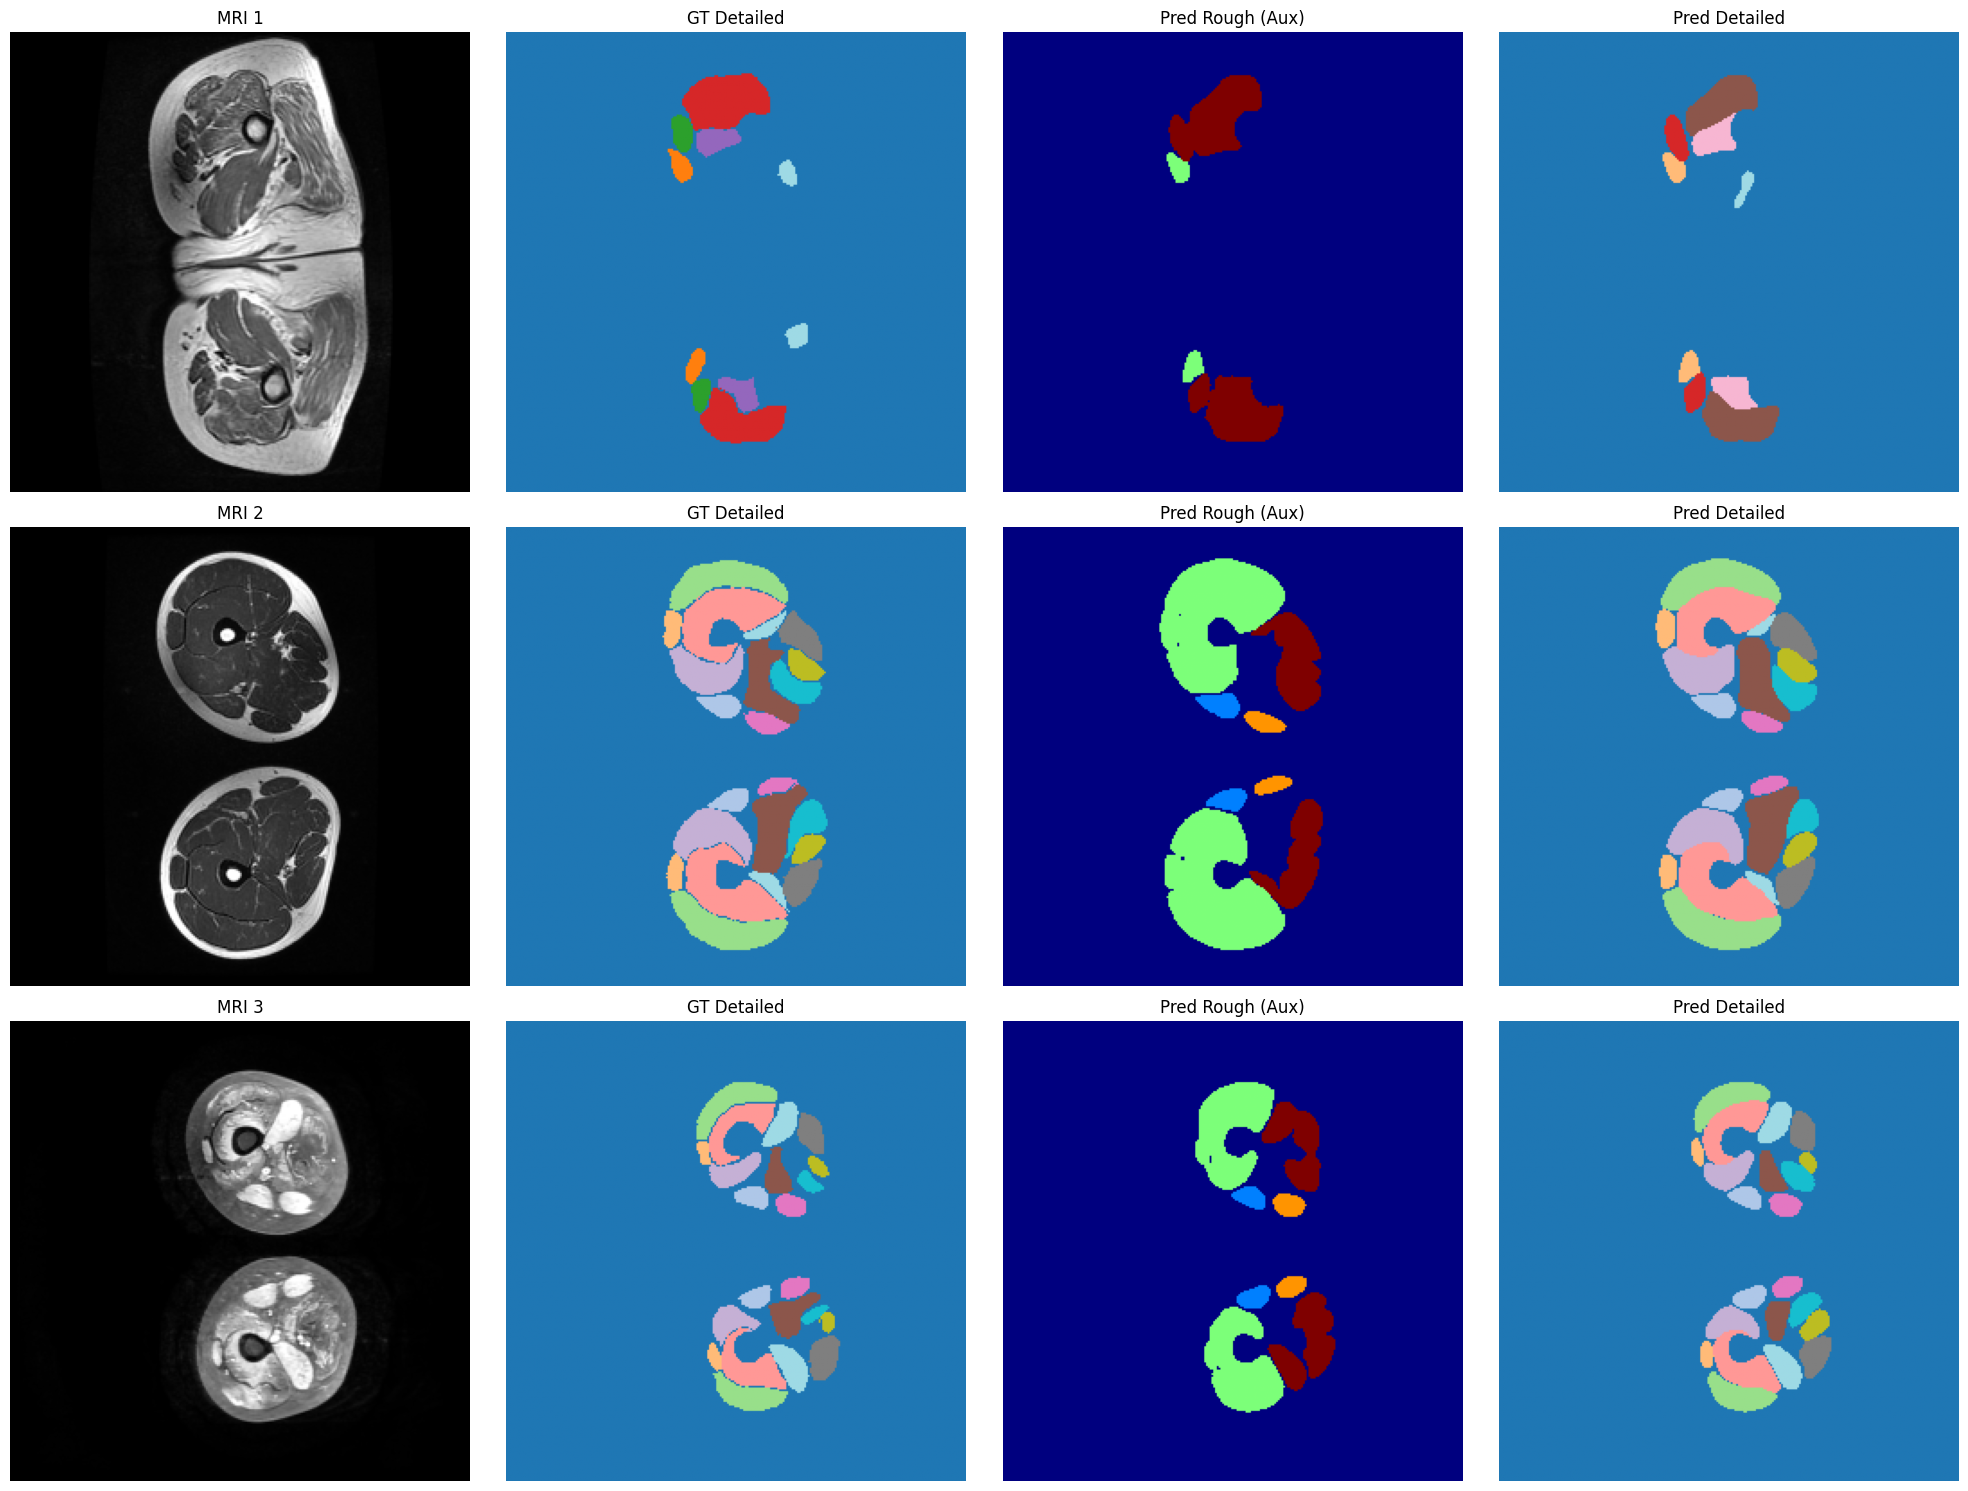

In [15]:
# ==========================================
# 1. 安裝必要的套件
# ==========================================
import sys
import subprocess

def install_packages():
    packages = [
        "nibabel", "matplotlib", "opencv-python",
        "segmentation-models-pytorch", "albumentations", "pandas", "tqdm"
    ]
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("⏳ 正在檢查與安裝套件...")
install_packages()
print("✅ 套件準備完成。")

# ==========================================
# 2. 匯入函式庫
# ==========================================
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ==========================================
# 3. 全域參數設定
# ==========================================
DATASET_ROOT = './2D_dataset/2D_dataset'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
LR = 0.0003
EPOCHS = 30
IMG_SIZE = (256, 256)

# 詳細肌肉類別 (12類)
DETAILED_CLASSES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 7: 'Gracilis',
    8: 'Biceps Femoris (Long)', 9: 'Semitendinosus', 10: 'Semimembranosus', 11: 'Biceps Femoris (Short)'
}

# 粗略肌群映射 (5類)
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

print(f"✅ 參數設定完成。使用裝置: {DEVICE}")

# ==========================================
# 4. 資料增強管線 (修正參數警告)
# ==========================================
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        # 修正: 移除舊版參數 alpha_affine
        A.ElasticTransform(alpha=1, sigma=50, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GridDistortion(p=0.2),
    ]
    return A.Compose(train_transform)

# ==========================================
# 5. Dataset 定義
# ==========================================
class MultiTaskThighDataset(Dataset):
    def __init__(self, file_pairs, target_size=(256, 256), transform=None):
        self.file_pairs = file_pairs
        self.target_size = target_size
        self.transform = transform
        self.mapping = ROUGH_MAPPING

    def __len__(self):
        return len(self.file_pairs)

    def preprocess_image(self, img):
        img = img.astype(np.float32)
        # 簡單防呆
        if img.size == 0 or img.max() == 0: return img

        lower = np.percentile(img, 0.5)
        upper = np.percentile(img, 99.5)
        img = np.clip(img, lower, upper)

        div = upper - lower
        if div > 0:
            img = (img - lower) / div
        else:
            img = img - lower
        return img

    def map_detailed_to_rough(self, detailed_mask):
        rough_mask = np.zeros_like(detailed_mask)
        for det_id, rough_id in self.mapping.items():
            rough_mask[detailed_mask == det_id] = rough_id
        return rough_mask

    def __getitem__(self, idx):
        img_path, lbl_path = self.file_pairs[idx]
        try:
            nii_img = nib.load(img_path)
            image_data = np.squeeze(nii_img.get_fdata())
            nii_lbl = nib.load(lbl_path)
            det_mask = np.squeeze(nii_lbl.get_fdata())

            image_data = self.preprocess_image(image_data)
            image_data = cv2.resize(image_data, self.target_size, interpolation=cv2.INTER_LINEAR)
            det_mask = cv2.resize(det_mask, self.target_size, interpolation=cv2.INTER_NEAREST)

            if self.transform:
                augmented = self.transform(image=image_data, mask=det_mask)
                image_data = augmented['image']
                det_mask = augmented['mask']

            rough_mask = self.map_detailed_to_rough(det_mask)

            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            det_tensor = torch.from_numpy(det_mask).long()
            rough_tensor = torch.from_numpy(rough_mask).long()

            return image_tensor, det_tensor, rough_tensor

        except Exception as e:
            print(f"Error loading {os.path.basename(img_path)}: {e}")
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size).long(), torch.zeros(self.target_size).long()

# ==========================================
# 6. 資料切分函式
# ==========================================
def get_split_files(root_dir, val_ratio=0.2, random_seed=42):
    image_dir = os.path.join(root_dir, 'train', 'image')
    detailed_dir = os.path.join(root_dir, 'train', 'detailed_label')

    if not os.path.exists(detailed_dir):
        print(f"❌ 找不到路徑: {detailed_dir}")
        return [], []

    label_paths = sorted(glob.glob(os.path.join(detailed_dir, '*_detailed.nii.gz')))
    patient_map = {}

    print("🔍 正在依照病人 ID 進行分組...")
    for lbl_path in label_paths:
        filename = os.path.basename(lbl_path)
        match = re.search(r"(THIGH_\d+)", filename)
        pid = match.group(1) if match else "unknown"

        img_name = filename.replace('_detailed.nii.gz', '.nii.gz')
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            if pid not in patient_map: patient_map[pid] = []
            patient_map[pid].append((img_path, lbl_path))

    all_patients = list(patient_map.keys())
    if not all_patients: return [], []

    train_pids, val_pids = train_test_split(all_patients, test_size=val_ratio, random_state=random_seed)

    train_files, val_files = [], []
    for pid in train_pids: train_files.extend(patient_map[pid])
    for pid in val_pids: val_files.extend(patient_map[pid])

    return train_files, val_files

# ==========================================
# 7. 雙頭模型 (修正 TypeError)
# ==========================================
class DualHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        self.encoder = self.base_model.encoder
        self.decoder = self.base_model.decoder

        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1) # 12類
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)    # 5類

    def forward(self, x):
        features = self.encoder(x)

        # [修正] 這裡直接傳入 list，不要用 *features 拆開
        # 舊版/部分版本 SMP 需要拆開，但新版 UnetDecoder.forward 只接受一個 list 參數
        decoder_output = self.decoder(features)

        out_detailed = self.head_detailed(decoder_output)
        out_rough = self.head_rough(decoder_output)

        return out_detailed, out_rough

# ==========================================
# 8. 評估指標計算
# ==========================================
def compute_class_metrics(pred_mask, true_mask, num_classes):
    dice_scores = []
    if isinstance(pred_mask, torch.Tensor): pred_mask = pred_mask.cpu().numpy()
    if isinstance(true_mask, torch.Tensor): true_mask = true_mask.cpu().numpy()

    for c in range(num_classes):
        p, t = (pred_mask == c), (true_mask == c)
        intersection = (p & t).sum()
        union = p.sum() + t.sum()
        dice = (2.0 * intersection) / (union + 1e-6) if union > 0 else np.nan
        dice_scores.append(dice)
    return dice_scores

# ==========================================
# 9. 訓練主程式
# ==========================================
def run_multitask_training():
    train_files, val_files = get_split_files(DATASET_ROOT)
    if not train_files:
        print("❌ 錯誤：找不到訓練資料。")
        return

    train_ds = MultiTaskThighDataset(train_files, target_size=IMG_SIZE, transform=get_training_augmentation())
    val_ds = MultiTaskThighDataset(val_files, target_size=IMG_SIZE, transform=None)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = DualHeadUNet().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    criterion_dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    criterion_focal = smp.losses.FocalLoss(mode='multiclass')

    print(f"\n🚀 開始 Multi-Task 訓練 (Detailed + Rough) ...")
    best_score = 0.0
    save_path = 'best_thigh_model_multitask.pth'

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for imgs, det_masks, rough_masks in loop:
            imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

            optimizer.zero_grad()
            out_det, out_rough = model(imgs)

            loss_d = criterion_dice(out_det, det_masks) + criterion_focal(out_det, det_masks)
            loss_r = criterion_dice(out_rough, rough_masks) + criterion_focal(out_rough, rough_masks)

            loss = loss_d + 0.5 * loss_r

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # --- Validation ---
        model.eval()
        val_loss = 0
        class_dice_sums = {i: [] for i in range(12)}

        with torch.no_grad():
            for imgs, det_masks, rough_masks in val_loader:
                imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

                out_det, out_rough = model(imgs)

                loss_d = criterion_dice(out_det, det_masks) + criterion_focal(out_det, det_masks)
                val_loss += loss_d.item()

                pred_labels = torch.argmax(out_det, dim=1)
                for i in range(len(pred_labels)):
                    d_scores = compute_class_metrics(pred_labels[i], det_masks[i], 12)
                    for cls_idx, score in enumerate(d_scores):
                        if not np.isnan(score): class_dice_sums[cls_idx].append(score)

        mean_dice_per_class = [np.mean(scores) if scores else 0.0 for i, scores in class_dice_sums.items()]
        avg_muscle_dice = np.mean(mean_dice_per_class[1:])

        scheduler.step(val_loss)

        print(f"   📊 Val Loss(Det): {val_loss/len(val_loader):.4f} | Muscle Dice: {avg_muscle_dice:.4f}")

        if avg_muscle_dice > best_score:
            best_score = avg_muscle_dice
            torch.save(model.state_dict(), save_path)
            print("   💾 Best Multi-Task Model Saved!")

    # --- 最終評估報告 ---
    print("\n" + "="*60)
    print("🏆 最終詳細評估報告")
    print("="*60)
    report_data = []
    for cls_idx in range(12):
        name = DETAILED_CLASSES[cls_idx]
        score = np.mean(class_dice_sums[cls_idx]) if class_dice_sums[cls_idx] else 0.0
        report_data.append({"Class ID": cls_idx, "Name": name, "Dice": score})

    df = pd.DataFrame(report_data)
    print(df.to_string(index=False, formatters={"Dice": "{:.4f}".format}))
    print("-" * 60)
    print(f"🔥 Final Average Muscle Dice: {avg_muscle_dice:.4f}")

    # --- 視覺化 ---
    visualize_loader = DataLoader(val_ds, batch_size=1, shuffle=True)
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    model.load_state_dict(torch.load(save_path))
    model.eval()

    with torch.no_grad():
        for i, (img, gt_det, gt_rough) in enumerate(visualize_loader):
            if i >= 3: break

            img_gpu = img.to(DEVICE)
            out_det, out_rough = model(img_gpu)

            p_det = torch.argmax(out_det, dim=1).squeeze().cpu().numpy()
            p_rough = torch.argmax(out_rough, dim=1).squeeze().cpu().numpy()

            img_vis = img.squeeze().permute(1, 2, 0).cpu().numpy()
            img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

            axes[i, 0].imshow(img_vis, cmap='gray'); axes[i, 0].set_title(f"MRI {i+1}")
            axes[i, 1].imshow(gt_det.squeeze(), cmap='tab20'); axes[i, 1].set_title("GT Detailed")
            axes[i, 2].imshow(p_rough, cmap='jet'); axes[i, 2].set_title("Pred Rough (Aux)")
            axes[i, 3].imshow(p_det, cmap='tab20'); axes[i, 3].set_title("Pred Detailed")
            for ax in axes[i]: ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    if os.path.exists(DATASET_ROOT):
        run_multitask_training()
    else:
        print(f"❌ 錯誤：找不到資料集 {DATASET_ROOT}")